# Analisis de Cabanna

## 1 Limpieza de datos


**Unificación de CSV diarios de Tijuana**

**Objetivo:** consolidar los archivos diarios de ventas de la sucursal **Tijuana** en una sola base limpia y analítica para usarla en el EDA y los modelos.

**Fuente de datos**

* Carpeta del proyecto: `Cabanna/`
* Ruta de los datos: `Data/Tijuana/`
* Patrón de archivos: `Ventas_Tijuana_<día>_<mes_esp>_<año>.csv`
  **Ejemplo:** `Ventas_Tijuana_1_ago_2025.csv`
* Estructura de columnas en cada CSV:

  * `ARTICULO` → nombre del producto
  * `cod` → código del artículo
  * `VENTAS` → número de veces que se vendió ese artículo en ese día

**Proceso seguido**

1. **Descubrimiento de archivos**
   Se listaron todos los CSV que cumplen el patrón `Ventas_Tijuana_*.csv` dentro de `Data/Tijuana/`.

2. **Extracción de la fecha desde el nombre del archivo**

   * Se aplicó una expresión regular para capturar `día`, `mes` (abreviado en español: `ene`, `feb`, …, `ago`, `sep`, `oct`, `nov`, `dic`) y `año`.
   * Se mapeó el mes abreviado a su número (p. ej., `ago` → `8`), y se construyó una fecha `FECHA` con formato de fecha real (Timestamp).

3. **Lectura robusta y normalización de columnas**

   * Se leyó cada CSV en **UTF-8** (tolerante a variaciones comunes).
   * Se estandarizaron los nombres de columnas a mayúsculas: `ARTICULO`, `COD`, `VENTAS`.
   * Limpieza y tipos:

     * `ARTICULO`: `str.strip()` para eliminar espacios y mantener consistencia.
     * `COD`: convertido a numérico con manejo de errores y guardado como entero nullable (`Int64`).
     * `VENTAS`: convertido a entero; valores no numéricos o vacíos se transformaron a 0.
   * Se agregó la columna fija `SUCURSAL = "Tijuana"`.

4. **Apilado (concatenación) de todos los días**

   * Se seleccionaron y ordenaron las columnas finales: `FECHA`, `SUCURSAL`, `COD`, `ARTICULO`, `VENTAS`.
   * Se concatenaron todos los DataFrames diarios en un solo DataFrame maestro.

5. **Validaciones de calidad**

   * Verificación de **nulos** en campos clave (`FECHA`, `COD`, `SUCURSAL`, `ARTICULO`).
   * Chequeo de **ventas negativas** (no deberían existir).
   * Conteo de **duplicados exactos** para identificar posibles reprocesos.



### Ventas

In [1]:
# === Configuración de rutas y librerías ===
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from rapidfuzz import process, fuzz
from unidecode import unidecode

from mlxtend.frequent_patterns import apriori, association_rules
from io import StringIO



def buscar_en_menu(busqueda):
    """
    Busca una palabra en todas las categorías y columnas relevantes del menú.
    
    Args:
        busqueda (str): La palabra clave a buscar.
        
    Returns:
        list: Una lista de tuplas con el formato (categoría, nombre_platillo)
              para cada coincidencia encontrada.
    """
    resultados = []
    busqueda_lower = busqueda.lower()

    for categoria, df in menu_dict.items():
        # Columnas donde se realizará la búsqueda
        columnas_a_buscar = ['Nombre_platillo', 'Descripcion', 'Licor', 'Tipo', 'Pais', 'Tamaño']
        
        # Filtra las columnas que realmente existen en el DataFrame
        columnas_existentes = [col for col in columnas_a_buscar if col in df.columns]

        for col in columnas_existentes:
            # Asegura que la columna es de tipo string y busca la palabra
            if pd.api.types.is_string_dtype(df[col]):
                coincidencias = df[df[col].astype(str).str.contains(busqueda_lower, case=False, na=False)]
                
                # Si se encuentran coincidencias, las agrega a la lista de resultados
                for _, row in coincidencias.iterrows():
                    nombre_platillo = row['Nombre_platillo']
                    if (categoria, nombre_platillo) not in resultados: # Evita duplicados
                        resultados.append((categoria, nombre_platillo))
                        
    return resultados



In [2]:
# guarda este archivo como scripts/merge_tijuana.py y ejecútalo desde la carpeta Cabanna:
#   python scripts/merge_tijuana.py

BASE = Path(".")  # carpeta actual
DATA_DIR = BASE / "Data" / "Tijuana"
OUT_DIR = BASE / "Data" / "Outputs"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Mapeo de meses en español abreviado
MES = {"ene":1,"feb":2,"mar":3,"abr":4,"may":5,"jun":6,"jul":7,"ago":8,"sep":9,"oct":10,"nov":11,"dic":12}

# Regex para archivos: Ventas_Tijuana_1_ago_2025.csv
pat = re.compile(r"Ventas_Tijuana_(\d{1,2})_([a-z]{3})_(\d{4})\.csv", re.IGNORECASE)

files = sorted([p for p in DATA_DIR.glob("Ventas_Tijuana_*.csv") if pat.match(p.name)])
if not files:
    raise SystemExit(f"No encontré archivos en {DATA_DIR}")

dfs = []
for f in files:
    m = pat.match(f.name)
    d, mmm, y = int(m.group(1)), m.group(2).lower(), int(m.group(3))
    month = MES.get(mmm)
    if not month:
        raise ValueError(f"Mes no reconocido en {f.name}")
    fecha = pd.Timestamp(year=y, month=month, day=d)

    # leemos con tolerancia a encoding y separadores
    df = pd.read_csv(f, encoding="utf-8", sep=",")
    # normalizar nombres
    df.columns = [c.strip().upper() for c in df.columns]
    # renombrar si vienen con variaciones
    df = df.rename(columns={"ARTICULO":"ARTICULO", "COD":"COD", "VENTAS":"VENTAS"})
    # limpieza básica
    df["ARTICULO"] = df["ARTICULO"].astype(str).str.strip()
    df["COD"] = pd.to_numeric(df["COD"], errors="coerce").astype("Int64")
    df["VENTAS"] = pd.to_numeric(df["VENTAS"], errors="coerce").fillna(0).astype(int)
    df["SUCURSAL"] = "Tijuana"
    df["FECHA"] = fecha
    dfs.append(df[["FECHA","SUCURSAL","COD","ARTICULO","VENTAS"]])

full = pd.concat(dfs, ignore_index=True)

# Validaciones rápidas
assert full[["FECHA","COD","SUCURSAL","ARTICULO"]].notna().all().all(), "Hay nulos inesperados"
# ventas negativas no deberían existir
neg = full[full["VENTAS"] < 0]
if not neg.empty:
    print("Advertencia: ventas negativas encontradas, revisa:")
    print(neg.head())
full = full[full["VENTAS"] > 0].copy()
# Guardar
#full.to_csv(OUT_DIR / "ventas_tijuana_diarias_limpio.csv", index=False)
#full.to_parquet(OUT_DIR / "ventas_tijuana_diarias_limpio.parquet", index=False)

# Resumen útil en consola
print(f"Archivos procesados: {len(files)}")
print(f"Artículos únicos: {full['ARTICULO'].nunique()}")
print(f"Rango de fechas: {full['FECHA'].min().date()} a {full['FECHA'].max().date()}")
full.head(5)

Archivos procesados: 137
Artículos únicos: 440
Rango de fechas: 2025-04-01 a 2025-08-17


FECHA SUCURSAL   COD              ARTICULO  VENTAS
0 2025-04-10  Tijuana   109  TACO KESITOS CABANNA     148
1 2025-04-10  Tijuana    14       TOST. ATUN AZUL      73
2 2025-04-10  Tijuana   300          CAMARON ROCA      73
3 2025-04-10  Tijuana  1073            CERV ULTRA      61
4 2025-04-10  Tijuana  1056           CERV CORONA      57

**Resultado obtenido**

* **Base unificada** con un registro por **producto–día** para la sucursal **Tijuana**.
* Columnas: `FECHA`, `SUCURSAL`, `COD`, `ARTICULO`, `VENTAS`.
* La base está **lista para análisis**: permite agregaciones por fecha, producto o combinación, construcción de canastas diarias y cálculo de métricas de desempeño por artículo.

> **Conclusión:** ahora contamos con una **tabla maestra consolidada y normalizada** de ventas diarias de Tijuana, lista para ejecutar EDA, clustering de productos, reglas de asociación y detección de productos ancla.

### Menu



### Introducción

El presente análisis tuvo como objetivo **integrar la información de ventas históricas** con el catálogo de productos del menú, con el fin de clasificar cada artículo vendido según su categoría (hoja de menú) y contar con datos limpios para estudios posteriores de comportamiento y rentabilidad.

Para lograrlo, se desarrolló un proceso de **mapeo automatizado con validación manual**, combinando técnicas de coincidencia aproximada (`fuzzy matching`) y correcciones supervisadas para asegurar la mayor precisión posible.

#### Actividades realizadas

1. **Preparación de datos**

   * Limpieza del archivo `ventas` y del archivo `menu` proveniente de múltiples hojas (clasificaciones como *Aguachiles*, *Tacos\_Res*, *Bebidas*, etc.).
   * Normalización de nombres para evitar problemas por mayúsculas, acentos o caracteres especiales.

2. **Construcción del catálogo unificado**

   * Extracción de todos los platillos únicos del menú (`menu_dict`).
   * Consolidación de un catálogo con su **Nombre\_platillo** y **Clasificación** (hoja de origen).

3. **Matching aproximado ARTICULO ↔ Nombre\_platillo**

   * Aplicación de `rapidfuzz` con un umbral inicial de similitud (≥85%) para identificar coincidencias.
   * Registro del **SCORE** de similitud para cada artículo de ventas.

4. **Correcciones manuales**

   * Revisión de los matches con `SCORE` alto.
   * Aplicación de ajustes en casos específicos (ej. *AG LIMON DE FRESA → Limonada de Fresa*, *BOT MARIATINTO TEMP → MARIATINTO*).

5. **Generación del DataFrame final (`full_mapeado`)**

   * Unión de ventas con el menú clasificado.
   * Incorporación de las correcciones validadas.

6. **Identificación de artículos no mapeados**

   * Detección de registros con `NOMBRE_PLATILLO = NaN`.
   * Análisis estadístico de su peso relativo (participación en ventas, sucursales más afectadas, artículos más frecuentes).

7. **Base lista para análisis posteriores**

   * DataFrame final depurado y enriquecido, listo para exploraciones como top platillos, rentabilidad por categoría o tendencias por sucursal.




In [3]:
# =========== Construcción del catálogo unificado ========== #

# Ruta del archivo Excel
ruta_excel = r"C:\Users\julio\OneDrive\Documentos\Trabajo\Ideas Frescas\Proyectos\Cabanna\Data\Tijuana\menu_cabanna_tijuana.xlsx"  # o la ruta completa si está en otra carpeta


# Lee TODAS las hojas
menu_dict = pd.read_excel(ruta_excel, sheet_name=None)


Aguachiles = menu_dict['Aguachiles']
Tostadas_de_Ceviche = menu_dict['Tostadas_de_Ceviche']
Tacos_Playeros = menu_dict['Tacos_Playeros']
Tacos_Res = menu_dict['Tacos_Res'] 
Ensaladas = menu_dict['Ensaladas'] 
Tiraditos = menu_dict['Tiraditos'] 
Antojos_Cabanna = menu_dict['Antojos_Cabanna']
Pizzas_Cabanna = menu_dict['Pizzas_Cabanna'] 
Antojos_Playeros = menu_dict['Antojos_Playeros']
Postres = menu_dict['Postres']
Bebidas = menu_dict['Bebidas']
Mixologia_Sin_Alcohol = menu_dict['Mixologia_Sin_Alcohol']
Mixologia = menu_dict['Mixologia']
Licores = menu_dict['Licores']
Vino = menu_dict['Vino']

In [4]:
# ========= 1) Funciones =========
def normalize_text(s: str) -> str:
    if pd.isna(s):
        return ""
    s = str(s)
    s = unidecode(s)               # quita acentos
    s = s.lower()                  # a minúsculas
    s = s.replace("_", " ")        # guiones bajos a espacios
    s = " ".join(s.split())        # espacios múltiples -> uno
    return s

def pick_name_column(df: pd.DataFrame):
    """Encuentra la columna de nombre del platillo."""
    candidates = [
        "Nombre_platillo", "nombre_platillo", "Nombre", "nombre",
        "Platillo", "platillo", "Producto", "producto"
    ]
    for c in candidates:
        if c in df.columns:
            return c
    # Si no se encontró, intenta heurística: primera columna de texto con variedad
    text_cols = [c for c in df.columns if df[c].dtype == "object"]
    return text_cols[0] if text_cols else df.columns[0]

# ========= 2) Construir catálogo unificado del menú =========
def build_menu_catalog(menu_dict: dict) -> pd.DataFrame:
    rows = []
    for clasif, df in menu_dict.items():
        if not isinstance(df, pd.DataFrame) or df.empty:
            continue
        name_col = pick_name_column(df)
        df_local = df[[name_col]].dropna().copy()
        df_local["Nombre_platillo"] = df_local[name_col].astype(str)
        df_local["CLASIFICACION"] = clasif
        df_local["norm_name"] = df_local["Nombre_platillo"].map(normalize_text)
        # Evitar duplicados exactos dentro de misma clasificación
        df_local = df_local.drop_duplicates(subset=["norm_name", "CLASIFICACION"])
        rows.append(df_local[["Nombre_platillo", "CLASIFICACION", "norm_name"]])
    if not rows:
        return pd.DataFrame(columns=["Nombre_platillo", "CLASIFICACION", "norm_name"])
    catalog = pd.concat(rows, ignore_index=True)
    # Quitar duplicados globales por norm_name conservando la primera aparición
    catalog = catalog.drop_duplicates(subset=["norm_name"])
    return catalog

# ========= 3) Matching aproximado ARTICULO -> catálogo =========
def match_articles_to_menu(full: pd.DataFrame, menu_dict: dict,
                           threshold: int = 85,
                           scorer=fuzz.WRatio) -> pd.DataFrame:
    """
    Retorna un DF con columnas:
    ARTICULO, NOMBRE_PLATILLO, CLASIFICACION, SCORE
    Si SCORE < threshold, deja NOMBRE_PLATILLO y CLASIFICACION vacíos.
    """
    # Artículos únicos
    art_unique = (full[["ARTICULO"]].drop_duplicates().copy())
    art_unique["norm_articulo"] = art_unique["ARTICULO"].map(normalize_text)

    # Catálogo del menú
    catalog = build_menu_catalog(menu_dict).copy()

    # Si el catálogo está vacío, devolvemos estructura vacía para validar luego
    if catalog.empty:
        out = art_unique.copy()
        out["NOMBRE_PLATILLO"] = ""
        out["CLASIFICACION"] = ""
        out["SCORE"] = 0
        return out[["ARTICULO", "NOMBRE_PLATILLO", "CLASIFICACION", "SCORE"]]

    # Lista de opciones (normalizadas) y mapa índice->fila
    choices = catalog["norm_name"].tolist()

    # Buscamos el mejor match para cada artículo
    best_names = []
    best_classes = []
    best_scores = []

    for q in art_unique["norm_articulo"].tolist():
        if not q:
            best_names.append("")
            best_classes.append("")
            best_scores.append(0)
            continue

        # process.extractOne devuelve (match_str, score, idx)
        match_res = process.extractOne(q, choices, scorer=scorer)
        if match_res is None:
            best_names.append("")
            best_classes.append("")
            best_scores.append(0)
            continue

        _, score, idx = match_res
        if score >= threshold:
            row = catalog.iloc[idx]
            best_names.append(row["Nombre_platillo"])
            best_classes.append(row["CLASIFICACION"])
            best_scores.append(int(score))
        else:
            best_names.append("")
            best_classes.append("")
            best_scores.append(int(score))

    mapping = art_unique.copy()
    mapping["NOMBRE_PLATILLO"] = best_names
    mapping["CLASIFICACION"] = best_classes
    mapping["SCORE"] = best_scores

    # Orden sugerida: mostrar primero los que NO alcanzaron el umbral
    mapping = mapping.sort_values(by=["NOMBRE_PLATILLO", "SCORE"], ascending=[True, False]).reset_index(drop=True)

    return mapping[["ARTICULO", "NOMBRE_PLATILLO", "CLASIFICACION", "SCORE"]]

# ========= 4) Ejecución =========
mapping_df = match_articles_to_menu(full, menu_dict, threshold=85, scorer=fuzz.WRatio)


# === 1) Correcciones manuales ===
correcciones = {
    "TACO KESITOS CABANNA":("Quesitos_Cabanna", "Tacos_Playeros"),
    "TACO KESITACO":("Quesitos_Cabanna", "Tacos_Playeros"),
    "VASO MICHELADO": ("", ""),  # nada
    "D PASTEL TRES LECHES": ("3 Leches", "Postres"),
    "PASTEL 3 LECHES SMORE": ("3 Leches S’more", "Postres"),
    "TACO CHE": ("Che", "Tacos_Res"),
    "ING EXTRA CHEF": ("", ""),
    "DESCORCHE": ("", ""),
    "AG LIMON DE FRESA": ("Limonada de Fresa", "Bebidas"),
    "APEROL FRESA MARACUYA": ("CAVA MIMOSA", "Mixologia"),
    "FRESCA": ("Refrescos", "Bebidas"),
    "AGUACH MANGOCHILE CAM": ("Mangochile_camaron", "Aguachiles"),
    "BOT MARIATINTO TEMP": ("MARIATINTO", "Vino"),
    "MARGARITA TAMARINDO":('MARGARITA MANGO', 'Mixologia'),			
    "TEQ D JULIO ANEJO": ('Don Julio Añejo', 'Licores'),			
    "MARINUGGUETS": ("",""),			
    "MARITIRITAS": ("",""),			
    "MARGARITA LIMON": ('MARGARITA MANGO', 'Mixologia'),			
    "WHI BUCHANNANS 12": ("Buchanan’s 12", "Licores"),			
    "FROZEN MARTINI MANZANA": ("FROZEN MARTINI COCO", "Mixologia"),			
    "FROZEN MARTINI GUANABANNA": ("FROZEN MARTINI COCO", "Mixologia"), 			
    "WHI BUCHANNANS 18": ("Buchanan’s 18", "Licores"),			
    "BROWNIE CHOCOCHIPS": ("",""),			
    "CAFE EXPRESS DOBLE": ("Expresso", "Bebidas"),			
    "COG HENESSYS": ("",""),			
    "CAM. CUCARACHA":  ("",""),			
    "COP WHI MACALLAN": ("",""),			
    "RONN PEPINNO": ("",""),			
    "WHI CHIVAS 12": ('Chivas Regal 12', 'Licores'),			
    "RON ZACAPAN 23 A": ("Zacapa 23 Años", "Licores"),
    "MARGARITA CADILAC": ("MARGARITA MANGO", "Mixologia"),
    "COP BCO HERENCIA CHARDONNAY": ("HERENCIA Palomino Chenin Blanc", "Vino"),
    "CERV MODELO ESP": ("Modelo_Especial", "Cerveza"),
    "AG  JAMAICA": ("Aguas_Frescas", "Bebidas"),
    "RUIDO": ("",""),
    "CERV STELLA": ("Stella_Artois", "Bebidas"),
    "FRIDA TEQUILA": ("",""),
    "D MARINUGETS CAM / PES": ("",""),
    "AGUACH 123 TAMARINDO CAM": ("",""),
    "D MARITIRITAS": ("",""),
    "COP EMEVE ARM TINTO": ("EMEVÉ ARMONÍA DE TINTOS", "Vino"),
    "AGUACH 123 TAMARINDO PESC": ("",""),
    "CONGA": ("",""),
    "BOT TTO MAGONI NEBBIOLO": ("CASA MAGONI (Nebbiolo)", "Vino"),
    "COCA ZERO": ("Refrescos", "Bebidas"),
    "AGUACH PELIRROJO CAM": ("Pelirrojo_camaron", "Aguachiles"),
    "AGUACH GRAN DUENDE CAM": ("GranDuende_camaron", "Aguachiles"),
    "TEQ D JULIO BCO": ("Don Julio Blanco", "Licores"),
    "BOT VINAS GARZA 2KM TEMP": ("VIÑAS DE GARZA 2 KM", "Vino"),
    "TARTA ELOTE": ("Pastel_Elote", "Postres"),
    'MEZ 400 CONE': ('400 Conejos', 'Licores'),
    'COP. VINAS GARZA 2KM TEMP': ("VIÑAS DE GARZA 2 KM", 'Vino'),
    'TEQ CENT REP': ("Centenario Reposado", 'Licores'),
    'BOT TTO STOS BRUJO TEMPRANILLO': ("SANTOS BRUJOS", 'Vino'),
    'TEQ HERRA REP':('Herradura Reposado', 'Licores'),
    'TEQ HERRA PLATA': ("Herradura Blanco", 'Licores'),
    'TEQ HERRA ULTR': ("Herradura Ultra", 'Licores'),
    'MEZ AMORES REP': ('Amores Reposado', 'Licores'),
    'COCA COLA': ("Refrescos", 'Bebidas'),
    'HORCHATA': ("Aguas_Frescas", 'Bebidas'),
    'AG NARANJADA MIN': ("Aguas_Frescas", 'Bebidas') ,
    'AG NARANJADA NAT': ("Aguas_Frescas", 'Bebidas'),
    'VOD STOLICHNAYA': ('PEPINO TENTACIÓN', 'Mixologia'),
    'AG LIMONADA NAT': ("Aguas_Frescas", 'Bebidas'),
    'AG LIMONADA MIN': ("Aguas_Frescas", 'Bebidas'),
    'TEQ D JULIO REP': ('Don Julio Reposado', 'Licores'),
    'TEQ MAESTRO TEQ ANEJO': ("Maestro Dobel Diamante", 'Licores'),
    'GIN JAR': ("GINGER 70", 'Mixologia'),
    'TEQ HERRA BCO': ('Herradura Blanco', 'Licores'),
    'SPRITE':  ("Refrescos", 'Bebidas'),
    'TEQ MAESTRO TEQ REP':("Maestro Dobel Diamante", 'Licores') ,
    'DIET COKE': ('Refrescos', 'Bebidas'),
    'TOSTADA ESP. CAM': ("Especial_de_Camaron", 'Tostadas_de_Ceviche'),
    'TEQ R FAM REP': ("Reserva de la familia Reposado", 'Licores'),
    'D PASTEL TRES LECHES': ("Tres_Leches", 'Postres'),
    'PASTEL 3 LECHES SMORE': ("Tres_Leches_Smore", 'Postres'),
    "CERV MODELO ESP": ("Modelo_Especial","Bebidas"),
    "CERV ULTRA": ("Michelob_Ultra","Bebidas"),

}



# === 2) Función para aplicar correcciones ===
def aplicar_correcciones(mapping_df, correcciones):
    df_corr = mapping_df.copy()
    for articulo, (nuevo_nombre, nueva_clasif) in correcciones.items():
        mask = df_corr["ARTICULO"] == articulo
        df_corr.loc[mask, "NOMBRE_PLATILLO"] = nuevo_nombre
        df_corr.loc[mask, "CLASIFICACION"] = nueva_clasif
    return df_corr

# === 3) Aplicar al mapping_df ===
mapping_df_corr = aplicar_correcciones(mapping_df, correcciones)

# Filtrar para mostrar solo los que tienen nombre de platillo
mapping_df_corr__con_nombre = mapping_df_corr[mapping_df_corr['NOMBRE_PLATILLO']!= ""]

# Filtro para mostrar los que NO tienen nombre de platillo
mapping_df_corr_sin_nombre = mapping_df_corr[mapping_df_corr['NOMBRE_PLATILLO']== ""]


# ========= 5) (Opcional) Unir el mapping a `full` =========
full_mapeado = full.merge(mapping_df_corr__con_nombre, on="ARTICULO", how="left")
full_mapeado.head()


FECHA SUCURSAL   COD              ARTICULO  VENTAS   NOMBRE_PLATILLO  \
0 2025-04-10  Tijuana   109  TACO KESITOS CABANNA     148  Quesitos_Cabanna   
1 2025-04-10  Tijuana    14       TOST. ATUN AZUL      73         Atun_Azul   
2 2025-04-10  Tijuana   300          CAMARON ROCA      73      Camarón Roca   
3 2025-04-10  Tijuana  1073            CERV ULTRA      61    Michelob_Ultra   
4 2025-04-10  Tijuana  1056           CERV CORONA      57            Corona   

         CLASIFICACION  SCORE  
0       Tacos_Playeros   85.0  
1  Tostadas_de_Ceviche   90.0  
2     Antojos_Playeros  100.0  
3              Bebidas   85.0  
4              Bebidas   90.0

In [5]:
# Ejemplo de uso
palabra_buscada = "Ultra"
resultados_busqueda = buscar_en_menu(palabra_buscada)

if resultados_busqueda:
    print(f"Resultados de la búsqueda para '{palabra_buscada}':\n")
    for categoria, platillo in resultados_busqueda:
        print(f"  - Platillo: {platillo}")
        print(f"    Categoría: {categoria}")
        print("-" * 30)
else:
    print(f"No se encontró ninguna coincidencia para la palabra '{palabra_buscada}'.")


Resultados de la búsqueda para 'Ultra':

  - Platillo: Michelob_Ultra
    Categoría: Bebidas
------------------------------
  - Platillo: Herradura Ultra
    Categoría: Licores
------------------------------


**Analisis de productos a descartar porque no se encontraron en la base de datos del menu**


1. **Identificar** los platillos descartados (los que no se encontraron en el menú: `NOMBRE_PLATILLO` es `NaN`).
2. **Cuantificar su “peso”** vs. el universo que sí se mapea (participación en ventas, conteos, etc.).
3. **Mostrar dónde pegan** (por sucursal, por artículo, por día) para decidir si vale la pena seguir corrigiendo o ignorarlos.
4. **Listar los “top”** (artículos y CODs) para una segunda ronda de limpieza si fuera necesario.




In [6]:

# --- 0) Copias base y flags ---
df = full_mapeado.copy()
df["is_na_menu"] = df["NOMBRE_PLATILLO"].isna()

# --- 1) Resumen general ---
tot_ventas = df["VENTAS"].sum()
tot_rows = len(df)
tot_articulos = df["ARTICULO"].nunique()

desc_df = df[df["is_na_menu"]]
keep_df = df[~df["is_na_menu"]]

desc_ventas = desc_df["VENTAS"].sum()
desc_rows = len(desc_df)
desc_articulos = desc_df["ARTICULO"].nunique()

keep_ventas = keep_df["VENTAS"].sum()
keep_rows = len(keep_df)
keep_articulos = keep_df["ARTICULO"].nunique()

resumen_general = pd.DataFrame({
    "metric": [
        "Ventas totales", "Filas totales", "Artículos únicos totales",
        "Ventas descartadas (NaN)", "Filas descartadas (NaN)", "Artículos únicos descartados (NaN)",
        "Ventas consideradas", "Filas consideradas", "Artículos únicos considerados",
        "% ventas descartadas", "% filas descartadas", "% artículos descartados"
    ],
    "valor": [
        tot_ventas, tot_rows, tot_articulos,
        desc_ventas, desc_rows, desc_articulos,
        keep_ventas, keep_rows, keep_articulos,
        (desc_ventas / tot_ventas)*100 if tot_ventas else 0,
        (desc_rows / tot_rows)*100 if tot_rows else 0,
        (desc_articulos / tot_articulos)*100 if tot_articulos else 0,
    ]
})
print("=== Resumen general ===")
print(resumen_general)

=== Resumen general ===
                                metric          valor
0                       Ventas totales  310631.000000
1                        Filas totales   30170.000000
2             Artículos únicos totales     440.000000
3             Ventas descartadas (NaN)   27103.000000
4              Filas descartadas (NaN)    3969.000000
5   Artículos únicos descartados (NaN)      79.000000
6                  Ventas consideradas  283528.000000
7                   Filas consideradas   26201.000000
8        Artículos únicos considerados     361.000000
9                 % ventas descartadas       8.725143
10                 % filas descartadas      13.155452
11             % artículos descartados      17.954545


In [7]:
# --- 2) Top artículos descartados (por ventas) ---
top_n = 30
top_desc_art = (desc_df
    .groupby(["ARTICULO"], as_index=False)["VENTAS"].sum()
    .sort_values("VENTAS", ascending=False)
    .head(top_n)
)
print(f"\n=== Top {top_n} ARTICULOS descartados (con COD) ===")
print(top_desc_art)


=== Top 30 ARTICULOS descartados (con COD) ===
                   ARTICULO  VENTAS
0           0 cambio mesero    4242
77           VASO MICHELADO    3885
75         TOPO CHICO 355ML    3468
76              VASO CUBANA    1789
61                    RUIDO    1744
53              ORD VERDURA    1028
64        SANGRIA PREPARADA     897
40           ING EXTRA CHEF     822
44             MARINUGGUETS     727
18       BROWNIE CHOCOCHIPS     719
35              FAJITAS REX     656
45              MARITIRITAS     618
56             PAPAS FRITAS     609
38     HAMBURGUESA INFANTIL     474
41   INGREDIENTE EXTRA FRIA     439
10            APEROL SPRITZ     383
39              HUGO SPRITZ     361
52           ORD TACO ASADA     344
36            FRIDA TEQUILA     316
58                   PIÑADA     291
54                PAJARITOS     261
11                   BAYLIS     250
1              1 BOLA NIEVE     244
70           TEQ 1800 CRIST     236
12           BEBIDA DEL MEs     219
57              

In [8]:
# --- 3) Tendencia temporal: % de ventas descartadas por día ---
# Asegúrate que FECHA sea datetime
df["FECHA"] = pd.to_datetime(df["FECHA"])
daily_tot = df.groupby("FECHA", as_index=False)["VENTAS"].sum().rename(columns={"VENTAS":"ventas_total"})
daily_desc = desc_df.groupby("FECHA", as_index=False)["VENTAS"].sum().rename(columns={"VENTAS":"ventas_desc"})
daily = daily_tot.merge(daily_desc, on="FECHA", how="left").fillna({"ventas_desc":0})
daily["pct_desc_ventas"] = daily["ventas_desc"] / daily["ventas_total"] * 100

print("\n=== % de ventas descartadas por día ===")
print(daily[["FECHA","pct_desc_ventas"]].sort_values("FECHA").tail(15))  # últimos 15 días para revisar


=== % de ventas descartadas por día ===
         FECHA  pct_desc_ventas
122 2025-08-02         7.725093
123 2025-08-03         7.602559
124 2025-08-04        11.953514
125 2025-08-06        10.196780
126 2025-08-07         8.953860
127 2025-08-08         8.665795
128 2025-08-09         9.154930
129 2025-08-10         7.024952
130 2025-08-11         8.849558
131 2025-08-12         9.898990
132 2025-08-13         9.724047
133 2025-08-14         8.867248
134 2025-08-15         9.987250
135 2025-08-16         9.595960
136 2025-08-17         8.225878


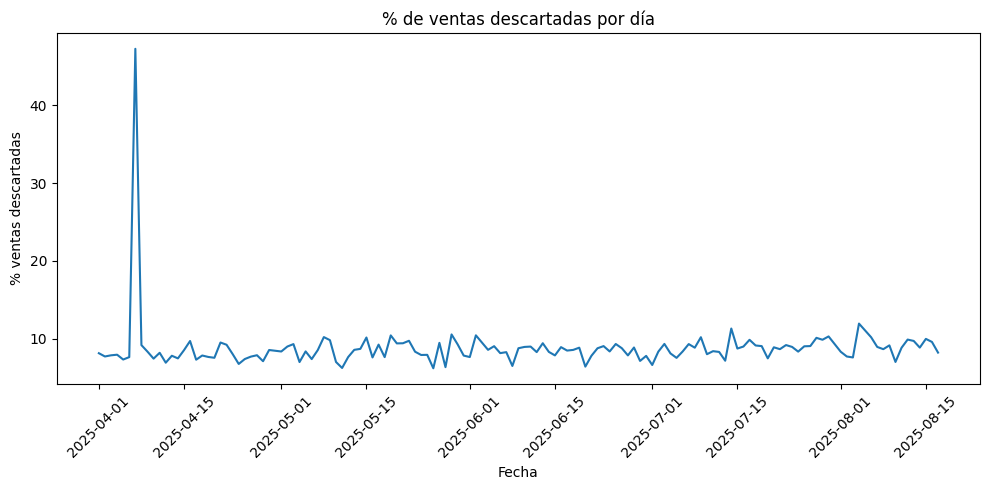

In [9]:
# --- 6) Visual rápida (opcional) ---
plt.figure(figsize=(10,5))
plt.plot(daily["FECHA"], daily["pct_desc_ventas"])
plt.title("% de ventas descartadas por día")
plt.xlabel("Fecha")
plt.ylabel("% ventas descartadas")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [10]:
# --- 7) Exportables útiles ---
# a) Resumen general
# resumen_general.to_csv("resumen_descartados_general.csv", index=False, encoding="utf-8-sig")
# b) Por sucursal
# by_suc.to_csv("descartados_por_sucursal.csv", index=False, encoding="utf-8-sig")
# c) Top artículos descartados
# top_desc_art.to_csv("top_articulos_descartados.csv", index=False, encoding="utf-8-sig")
# d) CODs más relevantes
# cod_desc.to_csv("cods_descartados.csv", index=False, encoding="utf-8-sig")

## Base de datos final

In [13]:

df_final = full_mapeado[full_mapeado['NOMBRE_PLATILLO'].notna()].copy()
df_final = df_final[['FECHA', 'SUCURSAL','NOMBRE_PLATILLO','CLASIFICACION','VENTAS']].copy()

# Copia de df_final
df_out = df_final.copy()

# 1) Normalizar nombres en ambos lados para que el join sea preciso
def normalize_text(s):
    if pd.isna(s):
        return ""
    import re
    from unidecode import unidecode
    s = str(s)
    s = unidecode(s).lower().strip()
    s = re.sub(r"\s+", "_", s)  # espacios -> _
    return s

df_out["norm_name"] = df_out["NOMBRE_PLATILLO"].map(normalize_text)

# 2) Crear catálogo de precios de todas las hojas
catalogo_precios = []

for clasif, df_menu in menu_dict.items():
    if not isinstance(df_menu, pd.DataFrame) or df_menu.empty:
        continue
    if "Nombre_platillo" not in df_menu.columns or "Precio" not in df_menu.columns:
        continue  # saltar si no hay las columnas clave
    
    df_menu_temp = df_menu.copy()
    df_menu_temp["CLASIFICACION"] = clasif
    df_menu_temp["norm_name"] = df_menu_temp["Nombre_platillo"].map(normalize_text)
    catalogo_precios.append(df_menu_temp[["CLASIFICACION", "norm_name", "Precio"]])

catalogo_precios = pd.concat(catalogo_precios, ignore_index=True)

# 3) Unir df_final con catálogo
df_out = df_out.merge(
    catalogo_precios,
    on=["CLASIFICACION", "norm_name"],
    how="left"
)

# 4) Calcular VENTAS $
df_out["INGRESO_ESTIMADO"] = df_out["VENTAS"] * df_out["Precio"]

# 5) Ordenar columnas como quieres
df_out = df_out[["FECHA", "SUCURSAL", "NOMBRE_PLATILLO", "Precio", "CLASIFICACION", "VENTAS", "INGRESO_ESTIMADO"]]
df_out.rename(columns={"Precio": "PRECIO_PLATILLO","VENTAS": "PLATILLOS_VENDIDOS"}, inplace=True)
df_out.to_csv("df_final_cabanna.csv", index=False, encoding="utf-8-sig")
df_out.head(20)


FECHA SUCURSAL       NOMBRE_PLATILLO  PRECIO_PLATILLO  \
0  2025-04-10  Tijuana      Quesitos_Cabanna             90.0   
1  2025-04-10  Tijuana             Atun_Azul            104.0   
2  2025-04-10  Tijuana          Camarón Roca            306.0   
3  2025-04-10  Tijuana        Michelob_Ultra             88.0   
4  2025-04-10  Tijuana                Corona             61.0   
5  2025-04-10  Tijuana   Especial_de_Camaron             89.0   
6  2025-04-10  Tijuana     Rib Eye Cabannero            319.0   
7  2025-04-10  Tijuana     Limonada de Fresa             64.0   
8  2025-04-10  Tijuana         Aguas_Frescas             58.0   
9  2025-04-10  Tijuana       MANDARIN MEZCAL            211.0   
10 2025-04-10  Tijuana      Quesitos_Cabanna             90.0   
11 2025-04-10  Tijuana          Pulpo_Mongol            108.0   
12 2025-04-10  Tijuana  Clamato_para_Cerveza             63.0   
13 2025-04-10  Tijuana                Helado            177.0   
14 2025-04-10  Tijuana             Refrescos             58.0   
15 2025-04-10  Tijuana              7_Chiles            124.0   
16 2025-04-10  Tijuana          Negra_Modelo             73.0   
17 2025-04-10  Tijuana       Taco_Gobernador             90.0   
18 2025-04-10  Tijuana       Modelo_Especial             73.0   
19 2025-04-10  Tijuana        Leche de Tigre            103.0   

          CLASIFICACION  PLATILLOS_VENDIDOS  INGRESO_ESTIMADO  
0        Tacos_Playeros                 148           13320.0  
1   Tostadas_de_Ceviche                  73            7592.0  
2      Antojos_Playeros                  73           22338.0  
3               Bebidas                  61            5368.0  
4               Bebidas                  57            3477.0  
5   Tostadas_de_Ceviche                  55            4895.0  
6       Antojos_Cabanna                  44           14036.0  
7               Bebidas                  44            2816.0  
8               Bebidas                  40            2320.0  
9             Mixologia                  35            7385.0  
10       Tacos_Playeros                  34            3060.0  
11       Tacos_Playeros                  34            3672.0  
12              Bebidas                  30            1890.0  
13              Postres                  30            5310.0  
14              Bebidas                  29            1682.0  
15  Tostadas_de_Ceviche                  28            3472.0  
16              Bebidas                  27            1971.0  
17       Tacos_Playeros                  26            2340.0  
18              Bebidas                  26            1898.0  
19     Antojos_Playeros                  25            2575.0

In [ ]:
df_out["NOMBRE_PLATILLO",	"PRECIO_PLATILLO"	"CLASIFICACION"	"PLATILLOS_VENDIDOS",	"INGRESO_ESTIMADO"]
df_out.groupby('NOMBRE_PLATILLO').sum().sort_values('INGRESO_ESTIMADO', ascending=False)
df_out.head(20)

TypeError: datetime64 type does not support sum operations


---

### 1. Análisis de productos y clusters

Meta: Identificar patrones de compra y grupos de productos que se venden juntos o que tienen comportamiento similar.
Entregables:

* Mapa de afinidad de productos: qué entradas, platillos y bebidas tienden a venderse juntas (para armar paquetes o sugerencias del mesero).
* Clusters de productos por sucursal: saber cuáles productos son “ganadores” en cada ubicación y cuáles tienen bajo rendimiento.
* Identificación de “productos ancla”: los que arrastran más ventas complementarias.

 **¿Qué es un mapa de afinidad?**

Un **mapa de afinidad de productos** es una representación (normalmente en forma de tabla o visual como un heatmap) que muestra **qué productos tienden a venderse juntos** en un mismo periodo de observación.
Como el periodo es **por día** (si un producto se vendió al menos una vez ese día, cuenta como presente en la “cesta” de ese día).



**Objetivo**

* **Detectar patrones de compra conjunta**: identificar pares o grupos de productos que suelen aparecer el mismo día, como si fueran “compañeros” de venta.
* **Encontrar oportunidades** para:

  * Crear **combos** o promociones cruzadas.
  * **Diseñar menús** con recomendaciones (“Si pides A, te puede gustar B”).
  * Detectar **hábitos de consumo** o productos que se asocian a eventos especiales.

**Para qué sirve**

1. **Marketing y ventas**

   * Promocionar juntos productos que ya tienen alta afinidad (sube ticket promedio).
2. **Operación y logística**

   * Planificar inventario sabiendo qué productos suelen salir juntos.
3. **Experiencia del cliente**

   * Ofrecer sugerencias personalizadas (cross-selling).
4. **Análisis estratégico**

   * Detectar relaciones inesperadas que revelen segmentos de clientes o patrones de consumo.



In [12]:
# 1) MAPA DE AFINIDAD (ventas conjuntas por DÍA)
# Cabana.ipynb — Análisis de Productos y Clusters
# ============================================
import pandas as pd
import numpy as np
from datetime import timedelta

# Opcionales / recomendados
from scipy.sparse import coo_matrix, csr_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# -----------------------------------------------------------
# 0) CONFIGURACIÓN INICIAL
# -----------------------------------------------------------
# Asume que ya tienes un DataFrame df con las columnas:
# FECHA, SUCURSAL, NOMBRE_PLATILLO, PRECIO_PLATILLO, CLASIFICACION, PLATILLOS_VENDIDOS, INGRESO_ESTIMADO

# Si lo necesitas, normaliza nombres de columnas:
rename_map = {
    "Fecha": "FECHA",
    "Sucursal": "SUCURSAL",
    "Nombre_platillo": "NOMBRE_PLATILLO",
    "Precio_platillo": "PRECIO_PLATILLO",
    "Clasificacion": "CLASIFICACION",
    "Platillos_vendidos": "PLATILLOS_VENDIDOS",
    "Ingreso_estimado": "INGRESO_ESTIMADO",
}
df = df_out.rename(columns={k: v for k, v in rename_map.items() if k in df.columns}).copy()

# Tipos
df["FECHA"] = pd.to_datetime(df["FECHA"], errors="coerce")
for c in ["PLATILLOS_VENDIDOS","INGRESO_ESTIMADO","PRECIO_PLATILLO"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.dropna(subset=["FECHA","SUCURSAL","NOMBRE_PLATILLO","CLASIFICACION","PLATILLOS_VENDIDOS","INGRESO_ESTIMADO"])

# Como solo hay UNA sucursal, opcionalmente fija:
SUCURSAL_UNICA = df["SUCURSAL"].iloc[0]

# Parámetros de análisis
MIN_SUPPORT_FRAC = 0.02     # soporte mínimo de par (>= 2% de los días) para reportar afinidad
MIN_SUPPORT_DAYS = 3        # o al menos 3 días en común (se aplica el máximo entre ambos criterios)
TOPK_PAIRS_PER_ITEM = 5     # pares top para cada producto
RANDOM_STATE = 42

# -----------------------------------------------------------
# 1) MAPA DE AFINIDAD (ventas conjuntas por DÍA)
# -----------------------------------------------------------
# Definimos "cesta" por día: si un producto vendió (>0) en un día, marcamos 1 (binario).
# Esto detecta productos que "aparecen" en el mismo día (proxy de afinidad sin tickets).

def build_daily_baskets(df_in: pd.DataFrame) -> dict:
    """Construye matriz binaria Días x Productos (1 si vendió ese día)."""
    tmp = (df_in
           .loc[df_in["PLATILLOS_VENDIDOS"] > 0, ["FECHA","NOMBRE_PLATILLO"]]
           .drop_duplicates())
    tmp["i_day"]  = tmp["FECHA"].astype("category").cat.codes.astype(np.int32)
    tmp["j_item"] = tmp["NOMBRE_PLATILLO"].astype("category").cat.codes.astype(np.int32)

    n_days  = tmp["i_day"].max()  + 1 if len(tmp) else 0
    n_items = tmp["j_item"].max() + 1 if len(tmp) else 0

    M = coo_matrix(
        (np.ones(len(tmp), dtype=np.uint8),
         (tmp["i_day"].values, tmp["j_item"].values)),
        shape=(n_days, n_items)
    ).tocsr()

    items = tmp["NOMBRE_PLATILLO"].astype("category").cat.categories.tolist()
    days  = tmp["FECHA"].astype("category").cat.categories.tolist()
    return {"X": M, "item_names": items, "days": pd.to_datetime(days)}

def affinity_from_baskets(X: csr_matrix, item_names: list,
                          min_support_frac=0.02, min_support_days=3, topk=5) -> pd.DataFrame:
    """
    Calcula afinidad entre productos (pares) usando soporte, lift, Jaccard y NPMI.
    Devuelve una tabla con los mejores pares (filtrados por soporte).
    """
    n_days, n_items = X.shape
    if n_days == 0 or n_items == 0:
        return pd.DataFrame(columns=["item_a","item_b","support_ab","lift","jaccard","npmi","cooc_days","support_a","support_b"])

    # Soportes individuales
    col_sums = np.asarray(X.sum(axis=0)).ravel()              # veces (días) que vendió el item
    support = col_sums / n_days                               # P(A)

    # Co-ocurrencias: X^T * X  -> matriz items x items con #días en común
    cooc = (X.T @ X).astype(np.float32)                       # puede ser grande, pero es dispersa
    cooc.setdiag(0)                                           # quitar diagonal (A con A)
    cooc_days = cooc.toarray()                                # para operar fácil (si muchos items, migrar a sparse ops)
    support_ab = cooc_days / n_days                           # P(A ∩ B)

    # Métricas
    # Lift = P(A ∩ B) / (P(A) * P(B))
    # Jaccard = P(A ∩ B) / P(A ∪ B) = cooc / (sumA + sumB - cooc) / n_days
    support_a = support.reshape(-1,1)
    support_b = support.reshape(1,-1)
    denom = (support_a @ support_b)                           # P(A)*P(B)
    with np.errstate(divide='ignore', invalid='ignore'):
        lift = np.where(denom>0, support_ab / denom, 0.0)
    # Jaccard:
    union = (support_a + support_b - support_ab)
    jaccard = np.where(union>0, support_ab / union, 0.0)
    # PMI y NPMI (normalizado)
    # PMI = log( P(A∩B) / (P(A)P(B)) ); NPMI = PMI / -log(P(A∩B))
    with np.errstate(divide='ignore', invalid='ignore'):
        pmi = np.log(np.where(denom>0, support_ab / denom, np.nan))
        npmi = pmi / (-np.log(np.clip(support_ab, 1e-12, 1.0)))
        npmi = np.nan_to_num(npmi, nan=0.0, neginf=0.0, posinf=0.0)

    # Filtro por soporte mínimo
    min_days = max(int(np.ceil(min_support_frac * n_days)), int(min_support_days))
    keep = cooc_days >= min_days
    idx_a, idx_b = np.where(keep)

    rows = []
    for a, b in zip(idx_a, idx_b):
        if a >= b:  # evitar duplicados (A,B) y (B,A)
            continue
        rows.append({
            "item_a": item_names[a],
            "item_b": item_names[b],
            "cooc_days": int(cooc_days[a,b]),
            "support_ab": support_ab[a,b],
            "support_a": support[a],
            "support_b": support[b],
            "lift": float(lift[a,b]),
            "jaccard": float(jaccard[a,b]),
            "npmi": float(npmi[a,b]),
        })

    aff = pd.DataFrame(rows)
    if aff.empty:
        return aff

    # Ranking: prioriza pares frecuentes y relevantes
    aff["score"] = aff["lift"] * aff["support_ab"]  # puedes ajustar el score
    aff = aff.sort_values(["score","lift","cooc_days"], ascending=False)

    # Top-K por producto (opcional, para que sea legible)
    if topk and topk > 0:
        aff = (aff
               .sort_values(["item_a","score"], ascending=[True,False])
               .groupby("item_a", as_index=False)
               .head(topk)
               .reset_index(drop=True))

    return aff[["item_a","item_b","cooc_days","support_ab","support_a","support_b","lift","jaccard","npmi"]]

# Construir cestas y afinidades (por sucursal actual)
df_s = df[df["SUCURSAL"] == SUCURSAL_UNICA].copy()
baskets = build_daily_baskets(df_s)
X = baskets["X"]; item_names = baskets["item_names"]; days = baskets["days"]

afinidad = affinity_from_baskets(
    X, item_names,
    min_support_frac=MIN_SUPPORT_FRAC,
    min_support_days=MIN_SUPPORT_DAYS,
    topk=TOPK_PAIRS_PER_ITEM
)
print("=== Mapa de afinidad (pares top por producto) ===")
display(afinidad.head(30))


=== Mapa de afinidad (pares top por producto) ===


item_a                  item_b  cooc_days  support_ab  \
0        400 Conejos       Chocolate_Savarin         76    0.554745   
1        400 Conejos        Camarón Mazatlán         77    0.562044   
2        400 Conejos        Quesitaco de Res         76    0.554745   
3        400 Conejos                  Bonita         77    0.562044   
4        400 Conejos              Lonja Zara         77    0.562044   
5           7_Chiles      Agua_Natural_Hethe        137    1.000000   
6           7_Chiles           Aguas_Frescas        137    1.000000   
7           7_Chiles               Atun_Azul        137    1.000000   
8           7_Chiles         BBQ Costillitas        137    1.000000   
9           7_Chiles    Burrito Mar & Tierra        137    1.000000   
10        ASTRONAUTA      Milanesa Quesitaco         59    0.430657   
11        ASTRONAUTA     Aguachile_de_la_tia         59    0.430657   
12        ASTRONAUTA           Chiles Torito         59    0.430657   
13        ASTRONAUTA                 Coqueta         59    0.430657   
14        ASTRONAUTA  Hamburguesa de la Casa         59    0.430657   
15      AYOXO MEZCAL                     Che         85    0.620438   
16      AYOXO MEZCAL        Panini Arrachera         83    0.605839   
17      AYOXO MEZCAL     Aguachile_de_la_tia         85    0.620438   
18      AYOXO MEZCAL                 Coqueta         85    0.620438   
19      AYOXO MEZCAL            Creme_Brulee         85    0.620438   
20           Absolut          BLUE MARGARITA         38    0.277372   
21           Absolut   Taquitos_de_Aguachile         41    0.299270   
22           Absolut                  Maguro         44    0.321168   
23           Absolut                     Che         44    0.321168   
24           Absolut     Aguachile_de_la_tia         44    0.321168   
25  Agua_Embotellada                     Che        111    0.810219   
26  Agua_Embotellada           Stella_Artois        110    0.802920   
27  Agua_Embotellada                  Bonita        111    0.810219   
28  Agua_Embotellada  Callo_de_Hacha_Natural        111    0.810219   
29  Agua_Embotellada      GranDuende_camaron        111    0.810219   

    support_a  support_b      lift   jaccard      npmi  
0    0.562044   0.948905  1.040160  0.580153  0.066822  
1    0.562044   0.978102  1.022388  0.574627  0.038428  
2    0.562044   0.963504  1.024400  0.571429  0.040911  
3    0.562044   0.992701  1.007353  0.566176  0.012715  
4    0.562044   0.992701  1.007353  0.566176  0.012715  
5    1.000000   1.000000  1.000000  1.000000  0.000000  
6    1.000000   1.000000  1.000000  1.000000  0.000000  
7    1.000000   1.000000  1.000000  1.000000  0.000000  
8    1.000000   1.000000  1.000000  1.000000  0.000000  
9    1.000000   1.000000  1.000000  1.000000  0.000000  
10   0.430657   0.978102  1.022388  0.440299  0.026282  
11   0.430657   0.985401  1.014815  0.437037  0.017457  
12   0.430657   0.985401  1.014815  0.437037  0.017457  
13   0.430657   0.985401  1.014815  0.437037  0.017457  
14   0.430657   0.985401  1.014815  0.437037  0.017457  
15   0.620438   0.978102  1.022388  0.634328  0.046385  
16   0.620438   0.934307  1.045129  0.638462  0.088079  
17   0.620438   0.985401  1.014815  0.629630  0.030809  
18   0.620438   0.985401  1.014815  0.629630  0.030809  
19   0.620438   0.985401  1.014815  0.629630  0.030809  
20   0.321168   0.708029  1.219775  0.368932  0.154918  
21   0.321168   0.832117  1.119817  0.350427  0.093803  
22   0.321168   0.970803  1.030075  0.330827  0.026089  
23   0.321168   0.978102  1.022388  0.328358  0.019494  
24   0.321168   0.985401  1.014815  0.325926  0.012948  
25   0.810219   0.978102  1.022388  0.828358  0.105208  
26   0.810219   0.970803  1.020795  0.820895  0.093767  
27   0.810219   0.992701  1.007353  0.816176  0.034811  
28   0.810219   0.992701  1.007353  0.816176  0.034811  
29   0.810219   0.992701  1.007353  0.816176  0.034811

**Componentes y cómo interpretarlos**

| Columna         | Qué significa                                                                                                                                         | Cómo interpretarlo                                                                                                                                             |
| --------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **item\_a**     | Primer producto del par analizado.                                                                                                                    | Producto de referencia desde el cual vemos su relación con `item_b`.                                                                                           |
| **item\_b**     | Segundo producto del par.                                                                                                                             | Producto que aparece junto con `item_a` en los mismos días.                                                                                                    |
| **cooc\_days**  | **Número de días** en que ambos productos se vendieron juntos.                                                                                        | Si es alto, significa que la relación se repite con frecuencia. Ej. 15 días en común = relación consistente.                                                   |
| **support\_ab** | **Proporción de días** en que ambos aparecieron juntos sobre el total de días analizados.                                                             | Ej. 0.08 = 8% de los días del periodo. Cuanto más alto, más frecuente es el par.                                                                               |
| **support\_a**  | **Proporción de días** en que `item_a` se vendió (solo, o con otros).                                                                                 | Si es muy alto, `item_a` es muy común.                                                                                                                         |
| **support\_b**  | Igual que `support_a` pero para `item_b`.                                                                                                             | Si ambos tienen soporte alto y *lift* también alto, la relación es muy fuerte.                                                                                 |
| **lift**        | Medida de **fuerza de la asociación**: compara la probabilidad real de que se vendan juntos con la probabilidad esperada si fueran independientes.    | >1 = se venden juntos más de lo esperado; 1 = sin relación; <1 = menos juntos de lo esperado. Ej. 2 = el doble de lo esperado; 5 = 5 veces más de lo esperado. |
| **jaccard**     | **Índice de similitud**: qué proporción de los días en que apareció al menos uno de los dos, aparecieron ambos.                                       | 1 = siempre juntos; 0.5 = la mitad de las veces que se vendió uno, se vendió el otro; 0 = nunca juntos.                                                        |
| **npmi**        | **PMI normalizado** (Normalized Pointwise Mutual Information): mide la fuerza de la relación corrigiendo por la rareza y normalizando entre \[-1, 1]. | 1 = asociación perfecta; 0 = sin relación; negativo = se evitan. Ayuda a comparar asociaciones entre pares con diferentes soportes.                            |


 **Patrones fuertes y consistentes**

* Resultados:

  * **400 Conejos** con *CLAMARINDO X1* y con *Carnitas de Atún*:

    * Aparecen juntos en 18 de los días (45% del total), con **lift ≈ 1.18** y **jaccard ≈ 0.54** →
      Esto indica que *casi la mitad de los días* en que se vendió 400 Conejos también se vendieron esos platillos, más frecuente de lo esperado.
  * **Absolut** con *PEPINO TENTACIÓN*:

    * 40% de días, lift 1.33, jaccard 0.53, npmi 0.31 → buena afinidad cruzada entre coctelería y destilado.
  * **Agua Embotellada** con varios acompañantes (*Stella Artois, CAVA MIMOSA, Ceviche Loreto, Bonita, Callo de Hacha*):

    * Altos soportes (>80%), lifts cercanos a 1.02–1.07 → esto más que afinidad exclusiva indica que *Agua Embotellada* es un producto omnipresente, que se combina con casi todo.


**Casos extremos sin valor analítico**

* Todos los pares con **7\_Chiles** tienen soporte = 1.0, lift = 1.0, jaccard = 1.0 →
  Esto significa que en *todos los días* ese producto apareció junto con los demás listados.

  * Puede ser un producto que **siempre está presente** en el menú o que **se vende en todas las transacciones**.
  * No aporta información para diferenciar afinidades, porque es omnipresente.

**Afinidades “especializadas” vs “acompañantes universales”**

* **Especializadas** → lifts > 1.2 con soporte medio, ej.:

  * *Absolut – BLUE MARGARITA* (lift 1.35, soporte 0.325)
  * *Absolut – PEPINO TENTACIÓN* (lift 1.33, soporte 0.4)
  * *ASTRONAUTA – Bombay* (lift 1.66, soporte 0.2)
    → Relación de bebidas específicas que comparten contexto de consumo (coctelería).
* **Universales** → lifts cercanos a 1.0 pero soportes muy altos:

  * *Agua Embotellada – Stella Artois*
  * *Agua Embotellada – Callo de Hacha Natural*
    → Agua acompaña a todo, por eso la afinidad es más por omnipresencia que por relación real.

 **Conclusión**

* **400 Conejos** y **Absolut** tienen afinidades interesantes para promociones cruzadas con coctelería y platos específicos.
* **7\_Chiles** y **Agua Embotellada** son productos “comodín” que aparecen con todo; no sirven para identificar combinaciones únicas, pero sí confirman su papel de *acompañantes básicos*.
* Los **lifts altos con soportes medios** (0.3–0.5) son los más valiosos comercialmente, porque señalan productos que *no siempre se venden, pero cuando lo hacen, tienden a ir juntos*.





---

**¿Qué es “Clusters de producto”?**

Un **cluster de producto** es un grupo de artículos que comparten patrones similares de comportamiento en ventas y otros indicadores clave.
El proceso consiste en usar técnicas de *machine learning* (en este caso, **K-Means**) para segmentar los productos en grupos homogéneos según métricas como:

* Qué tan frecuente se venden (**support**)
* Cuánto ingreso generan (**rev\_per\_day**)
* Cuántas piezas venden cuando se venden (**avg\_qty\_on\_selling\_days**)
* Variabilidad de ventas (**cv\_qty**)
* Tendencia de ventas en el tiempo (**trend\_qty\_slope**)

En pocas palabras, es **clasificar los productos en categorías estratégicas** según su desempeño real, no solo por intuición.

 **Objetivo**

* **Detectar patrones** en el portafolio de productos.
* **Identificar prioridades**:

  * Potenciar los que funcionan mejor (**Ganadores**).
  * Mejorar o sustituir los que venden poco (**Bajo rendimiento**).
  * Dar seguimiento a los intermedios para que suban de nivel.
* **Optimizar inventarios y marketing** con base en evidencia y no en suposiciones.

 **¿Para qué sirve en la operación?**

1. **Decisiones de promoción**: saber qué productos impulsar en campañas.
2. **Estrategia de inventario**: ajustar stock para evitar quiebres o exceso.
3. **Diseño de menú**: decidir qué platillos mantener, ajustar o retirar.
4. **Monitoreo de tendencia**: anticipar caídas o crecimientos antes de que sean críticos.
5. **Priorización por sucursal**: no todos los productos se comportan igual en todas las plazas.

 **Descripción e interpretación de los componentes**

| Columna           | Qué significa                                                                                                  | Cómo interpretarlo                                                                                                                             |
| ----------------- | -------------------------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------- |
| **cluster**       | Número que identifica el grupo creado por K-Means. No tiene significado por sí solo, es solo un identificador. | Productos con el mismo número de `cluster` se comportan de manera similar en las variables analizadas.                                         |
| **n\_items**      | Cantidad de productos dentro de ese cluster.                                                                   | Un cluster con muchos productos implica que hay un patrón de desempeño común más extendido.                                                    |
| **rev\_per\_day** | **Ingreso promedio diario** que genera el producto (considerando todos los días, incluso los de cero ventas).  | Alto → producto estable y con gran aporte económico.<br>Bajo → ingreso reducido o ventas esporádicas.                                          |
| **support**       | Proporción de días en los que el producto tuvo al menos una venta sobre el total de días analizados.           | 1.0 = se vendió todos los días.<br>0.2 = solo se vendió en el 20% de los días.                                                                 |
| **qty\_mean**     | Cantidad promedio vendida por día (incluyendo ceros).                                                          | Complementa el *support*: un producto puede venderse poco frecuente pero en grandes cantidades cuando lo hace.                                 |
| **trend**         | Pendiente de la tendencia de ventas a lo largo del tiempo.                                                     | Positiva (>0) → ventas van en aumento.<br>Negativa (<0) → ventas están cayendo.<br>Cercana a 0 → estables.                                     |
| **rol\_cluster**  | Etiqueta cualitativa asignada según `rev_per_day` y `support` en comparación con la mediana global.            | **Ganadores** = altos en ingreso y frecuencia.<br>**Bajo rendimiento** = bajos en ambos.<br>**Intermedios** = altos en uno y bajos en el otro. |



In [ ]:
# 2) CLUSTERS DE PRODUCTO (ganadores / promedio / bajo)
# -----------------------------------------------------------
# Features por producto (a nivel sucursal):
# - soporte (días con venta / total días)
# - total_qty, total_ingreso
# - ingreso_por_día (sobre todos los días, con ceros)
# - qty_media_día_con_venta
# - precio_median
# - CV_qty (variabilidad)
# - trend_qty_slope (pendiente simple de qty a lo largo del tiempo)

def build_product_daily_matrix(df_in: pd.DataFrame, days_index: pd.DatetimeIndex, item_order: list):
    """Matriz densa Items x Days con cantidades (PLATILLOS_VENDIDOS); ceros cuando no vendió."""
    # Tabla pivote con todos los días en columnas
    qty = (df_in
           .groupby(["FECHA","NOMBRE_PLATILLO"], as_index=False)["PLATILLOS_VENDIDOS"].sum())
    qty_p = (qty
             .pivot(index="NOMBRE_PLATILLO", columns="FECHA", values="PLATILLOS_VENDIDOS")
             .reindex(index=item_order, columns=days_index, fill_value=0)
             .astype(float))
    return qty_p

def product_features(df_in: pd.DataFrame, X_bin: csr_matrix, item_names: list, days: pd.DatetimeIndex) -> pd.DataFrame:
    n_days = len(days)
    # soporte individual
    sold_days = np.asarray(X_bin.sum(axis=0)).ravel().astype(int)
    support = sold_days / max(n_days, 1)

    # Totales
    by_prod = (df_in.groupby("NOMBRE_PLATILLO", as_index=False)
                  .agg(total_qty=("PLATILLOS_VENDIDOS","sum"),
                       total_rev=("INGRESO_ESTIMADO","sum"),
                       price_median=("PRECIO_PLATILLO","median")))
    by_prod = by_prod.set_index("NOMBRE_PLATILLO").reindex(item_names)

    # Matriz diaria de qty (Items x Days)
    qty_p = build_product_daily_matrix(df_in, days_index=days, item_order=item_names)
    # Métricas temporales
    mean_qty_all_days = qty_p.mean(axis=1)                      # incluye ceros
    qty_only_sold = qty_p.replace(0, np.nan)
    avg_qty_on_selling_days = qty_only_sold.mean(axis=1).fillna(0.0)
    # Coeficiente de variación (std/mean) usando todos los días
    cv_qty = qty_p.std(axis=1) / (qty_p.mean(axis=1) + 1e-6)

    # Tendencia (pendiente) — regresión simple con índice de tiempo
    t = np.arange(n_days)
    # slope = cov(t, qty) / var(t)
    var_t = np.var(t) + 1e-9
    slopes = []
    for i in range(qty_p.shape[0]):
        y = qty_p.iloc[i].values
        cov_ty = np.cov(t, y, bias=True)[0,1]
        slopes.append(cov_ty / var_t)
    trend_qty_slope = pd.Series(slopes, index=qty_p.index)

    # Ingreso por día (sobre todos los días)
    rev_per_day = by_prod["total_rev"] / max(n_days, 1)

    feats = pd.DataFrame({
        "NOMBRE_PLATILLO": item_names,
        "support": support,
        "sold_days": sold_days,
        "total_qty": by_prod["total_qty"].values,
        "total_rev": by_prod["total_rev"].values,
        "rev_per_day": rev_per_day.values,
        "avg_qty_on_selling_days": avg_qty_on_selling_days.values,
        "mean_qty_all_days": mean_qty_all_days.values,
        "price_median": by_prod["price_median"].values,
        "cv_qty": cv_qty.values,
        "trend_qty_slope": trend_qty_slope.values
    }).fillna(0.0)
    return feats

feats = product_features(df_s, X, item_names, days)

# K-Means con selección automática de k (2..6) por silhouette
def kmeans_auto(df_feats: pd.DataFrame, feature_cols: list, k_min=2, k_max=6, random_state=42):
    Xf = df_feats[feature_cols].values
    Xs = StandardScaler().fit_transform(Xf)
    best_k, best_score, best_model = None, -1, None
    for k in range(k_min, min(k_max, len(df_feats)-1)+1):
        km = KMeans(n_clusters=k, n_init=20, random_state=random_state)
        labels = km.fit_predict(Xs)
        if len(set(labels)) == 1:
            continue
        score = silhouette_score(Xs, labels)
        if score > best_score:
            best_k, best_score, best_model = k, score, km
    if best_model is None:
        # fallback k=2
        best_model = KMeans(n_clusters=2, n_init=20, random_state=random_state).fit(Xs)
        best_k = 2
    labels = best_model.predict(Xs)
    centers = pd.DataFrame(best_model.cluster_centers_, columns=feature_cols)
    centers = pd.DataFrame(StandardScaler().fit(df_feats[feature_cols]).transform(centers), columns=feature_cols)  # ya están escalados; mantenemos formato
    return labels, best_k, best_score, centers

feature_cols = ["rev_per_day","support","avg_qty_on_selling_days","price_median","cv_qty","trend_qty_slope"]
labels, k_opt, sil, centers = kmeans_auto(feats, feature_cols, random_state=RANDOM_STATE)
feats["cluster"] = labels

# Rol del cluster (ganador/promedio/bajo) según medias de rev_per_day y support del cluster
cluster_summary = (feats
    .groupby("cluster", as_index=False)
    .agg(
        n_items=("NOMBRE_PLATILLO","count"),
        rev_per_day=("rev_per_day","mean"),
        support=("support","mean"),
        qty_mean=("mean_qty_all_days","mean"),
        trend=("trend_qty_slope","mean")
    )
)

# Umbrales: mediana global
rev_med = feats["rev_per_day"].median()
sup_med = feats["support"].median()

def label_role(row):
    if row["rev_per_day"] >= rev_med and row["support"] >= sup_med:
        return "Ganadores"
    if row["rev_per_day"] < rev_med and row["support"] < sup_med:
        return "Bajo rendimiento"
    return "Intermedios"

cluster_summary["rol_cluster"] = cluster_summary.apply(label_role, axis=1)
feats = feats.merge(cluster_summary[["cluster","rol_cluster"]], on="cluster", how="left")

print(f"=== Clusters de producto (k={k_opt}, silhouette={sil:.3f}) — {SUCURSAL_UNICA} ===")
display(cluster_summary.sort_values("rev_per_day", ascending=False))
print("Muestra de asignaciones:")
display(feats[["NOMBRE_PLATILLO","total_rev","support","rev_per_day","cluster","rol_cluster"]].sort_values(["cluster","rev_per_day"], ascending=[True,False]).head(20))


In [ ]:
# 3) PRODUCTOS ANCLA (arrastran ventas complementarias)
# -----------------------------------------------------------
# Idea: un "anchor score" por producto A basado en su fuerza de co-ocurrencia con otros B.
# Definimos: anchor_score(A) = sum_B [ lift(A,B) * support(A∩B) ]
# (puedes ponderar además por share de ingreso de B)

def compute_anchor_scores(afinidad_df: pd.DataFrame, feats_df: pd.DataFrame) -> pd.DataFrame:
    if afinidad_df.empty:
        return pd.DataFrame(columns=["NOMBRE_PLATILLO","anchor_score","top_complements"])
    # Expandimos para tener ambas direcciones (A,B) y (B,A)
    a = afinidad_df.rename(columns={"item_a":"A","item_b":"B"}).copy()
    b = afinidad_df.rename(columns={"item_a":"B","item_b":"A"}).copy()
    ab = pd.concat([a,b], ignore_index=True)

    ab["contrib"] = ab["lift"] * ab["support_ab"]  # contribución de B al score de A
    score = ab.groupby("A", as_index=False)["contrib"].sum().rename(columns={"A":"NOMBRE_PLATILLO","contrib":"anchor_score"})

    # Top complementos por A
    ab_sorted = ab.sort_values(["A","contrib"], ascending=[True,False])
    top_comp = (ab_sorted.groupby("A")["B"].apply(lambda s: list(s.head(3))).reset_index()
                .rename(columns={"A":"NOMBRE_PLATILLO","B":"top_complements"}))

    out = score.merge(top_comp, on="NOMBRE_PLATILLO", how="left")
    # Añade rev_per_day de cada A para contexto
    out = out.merge(feats_df[["NOMBRE_PLATILLO","rev_per_day","support","rol_cluster"]], on="NOMBRE_PLATILLO", how="left")
    out = out.sort_values("anchor_score", ascending=False)
    return out

anchors = compute_anchor_scores(afinidad, feats)
print("=== Productos ancla (mayor arrastre complementario) ===")
display(anchors.head(20))

# (Opcional) Diferencia de ingreso promedio del resto cuando A está vs no está
# útil para validar anclas: días con A vs sin A
def complement_revenue_uplift(df_in: pd.DataFrame, target_item: str) -> float:
    # Ingreso de "otros" productos cuando target vende vs cuando no vende
    days_all = df_in["FECHA"].drop_duplicates().sort_values()
    sold_days = (df_in.loc[df_in["NOMBRE_PLATILLO"]==target_item, "FECHA"].drop_duplicates())
    sold_days_set = set(pd.to_datetime(sold_days))
    mask_sold = df_in["FECHA"].isin(sold_days_set)
    rev_when_sold    = df_in.loc[mask_sold & (df_in["NOMBRE_PLATILLO"]!=target_item), "INGRESO_ESTIMADO"].sum() / max(len(sold_days_set),1)
    rev_when_not     = df_in.loc[(~mask_sold) & (df_in["NOMBRE_PLATILLO"]!=target_item), "INGRESO_ESTIMADO"].sum() / max((len(days_all)-len(sold_days_set)),1)
    return rev_when_sold - rev_when_not

# Ejemplo de cálculo de uplift para los 5 anclas top:
if not anchors.empty:
    print("=== Uplift de ingreso promedio (otros) cuando el ancla vende (Top 5) ===")
    ups = []
    for item in anchors["NOMBRE_PLATILLO"].head(5):
        ups.append({"NOMBRE_PLATILLO": item, "rev_uplift_otros": complement_revenue_uplift(df_s, item)})
    display(pd.DataFrame(ups).sort_values("rev_uplift_otros", ascending=False))

In [ ]:
# Cabana.ipynb — Visuales ejecutivos y export para app.py
# ============================================
import os
import json
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Network (para el grafo de afinidad)
try:
    import networkx as nx
except ImportError:
    raise ImportError("Instala networkx: pip install networkx")

# Paleta y tema
TEMPLATE = "plotly_dark"
ACCENT = "#d4af37"

# ---------- Helpers ----------
def _exists(obj_name: str, glb: dict):
    return (obj_name in glb) and (glb[obj_name] is not None) and (not (isinstance(glb[obj_name], pd.DataFrame) and glb[obj_name].empty))

def _ensure_dir(path="exports"):
    os.makedirs(path, exist_ok=True)
    return path

# ---------- 0) Validaciones rápidas ----------
missing = []
for name in ["df", "afinidad", "feats", "cluster_summary", "anchors"]:
    if not _exists(name, globals()):
        missing.append(name)

if missing:
    print("⚠️ Faltan variables previas. Ejecuta el análisis primero. Faltan:", missing)
else:
    print("✓ Entradas detectadas: df, afinidad, feats, cluster_summary, anchors")

# ============ 1) KPIs ejecutivos (del rango completo cargado) ============
if _exists("df", globals()):
    df_k = df.copy()
    ingreso_total = df_k["INGRESO_ESTIMADO"].sum()
    platillos_total = df_k["PLATILLOS_VENDIDOS"].sum()
    ticket_aprox   = ingreso_total / platillos_total if platillos_total>0 else np.nan

    # Bebidas vs Alimentos
    def es_bebida(clasif: str) -> bool:
        s = str(clasif).lower()
        return ("bebida" in s) or ("cerveza" in s)
    df_k["TIPO"] = np.where(df_k["CLASIFICACION"].apply(es_bebida), "Bebidas", "Alimentos")

    mix_tipo = df_k.groupby("TIPO", as_index=False)["INGRESO_ESTIMADO"].sum()
    ing_beb = mix_tipo.query("TIPO=='Bebidas'")["INGRESO_ESTIMADO"].sum()
    ing_ali = mix_tipo.query("TIPO=='Alimentos'")["INGRESO_ESTIMADO"].sum()
    pct_beb = (ing_beb/ingreso_total*100) if ingreso_total>0 else 0
    pct_ali = (ing_ali/ingreso_total*100) if ingreso_total>0 else 0

    # Top producto
    top_prod = (df_k.groupby("NOMBRE_PLATILLO", as_index=False)
                  .agg(INGRESO=("INGRESO_ESTIMADO","sum"), UDS=("PLATILLOS_VENDIDOS","sum"))
                  .sort_values("INGRESO", ascending=False).head(1))
    prod_top_name = top_prod["NOMBRE_PLATILLO"].iloc[0] if not top_prod.empty else "-"
    prod_top_ing  = float(top_prod["INGRESO"].iloc[0]) if not top_prod.empty else 0.0
    prod_top_qty  = int(top_prod["UDS"].iloc[0]) if not top_prod.empty else 0

    # Tarjetas rápidas (como tabla simple + texto)
    print("=== KPIs Ejecutivos ===")
    kpi_tbl = pd.DataFrame({
        "KPI": ["Ingreso total", "Ticket (aprox)", "% Bebidas", "% Alimentos", "Producto TOP", "Ingreso TOP", "Uds TOP"],
        "Valor": [f"${ingreso_total:,.0f}", f"${ticket_aprox:,.2f}", f"{pct_beb:.1f}%", f"{pct_ali:.1f}%", prod_top_name, f"${prod_top_ing:,.0f}", prod_top_qty]
    })
    display(kpi_tbl)

    # Pie de % tipo
    fig_mix_tipo = px.pie(mix_tipo, names="TIPO", values="INGRESO_ESTIMADO", title="% ingreso: Bebidas vs Alimentos", hole=0.45, template=TEMPLATE)
    fig_mix_tipo.update_traces(textposition="inside", textinfo="percent+label")
    fig_mix_tipo.show()

# ============ 2) Afinidad de productos ============
if _exists("afinidad", globals()):
    print("=== Afinidad: top pares por producto (tabla) ===")
    display(afinidad.head(30))

    # Heatmap (si es manejable)
    # Construimos matriz simétrica con 'lift' para items en top-N por score
    N_HEAT = 20  # limita a los 20 productos con más co-ocurrencias para que sea legible
    # ranking de items por # de co-oc (cooc_days totales en cualquiera de sus pares)
    deg = (afinidad
           .melt(id_vars=["cooc_days","lift","item_a","item_b"], value_vars=["item_a","item_b"], value_name="item", var_name="_")
           .groupby("item", as_index=False)["cooc_days"].sum()
           .sort_values("cooc_days", ascending=False))
    top_items = deg["item"].head(N_HEAT).tolist()

    # pivote de lift para top_items
    aff_top = afinidad[(afinidad["item_a"].isin(top_items)) & (afinidad["item_b"].isin(top_items))].copy()
    if not aff_top.empty:
        M = aff_top.pivot(index="item_a", columns="item_b", values="lift").fillna(0)
        # simetrizar (tomamos max de A,B y B,A)
        M2 = M.combine_first(M.T)
        fig_heat = px.imshow(M2, color_continuous_scale="Viridis", title="Mapa de afinidad (lift) — Top productos", template=TEMPLATE)
        fig_heat.update_layout(xaxis_title="Producto B", yaxis_title="Producto A")
        fig_heat.show()

    # Grafo de afinidad (aristas por lift y soporte)
    # Filtro para un grafo legible:
    LIFT_MIN = 1.2
    COOC_MIN = 3
    edges = afinidad[(afinidad["lift"]>=LIFT_MIN) & (afinidad["cooc_days"]>=COOC_MIN)].copy()
    if not edges.empty:
        G = nx.Graph()
        for _, r in edges.iterrows():
            G.add_edge(r["item_a"], r["item_b"], weight=float(r["lift"]), cooc=int(r["cooc_days"]))

        # Posiciones
        pos = nx.spring_layout(G, seed=7, k=0.6)

        # Convertimos a scatter para Plotly
        edge_x, edge_y, edge_text = [], [], []
        for a, b, d in G.edges(data=True):
            x0, y0 = pos[a]; x1, y1 = pos[b]
            edge_x += [x0, x1, None]
            edge_y += [y0, y1, None]
            edge_text.append(f"{a} — {b}<br>lift={d['weight']:.2f} • días={d['cooc']}")

        node_x, node_y, node_text, node_deg = [], [], [], []
        for n in G.nodes():
            x, y = pos[n]
            node_x.append(x); node_y.append(y)
            node_text.append(n)
            node_deg.append(G.degree[n])

        edge_trace = go.Scatter(x=edge_x, y=edge_y, mode='lines', line=dict(width=1), hoverinfo='none', showlegend=False)
        node_trace = go.Scatter(
            x=node_x, y=node_y, mode='markers+text',
            marker=dict(size=[6+2*d for d in node_deg], color=ACCENT),
            text=node_text, textposition="top center", hoverinfo='text', showlegend=False
        )

        fig_graph = go.Figure(data=[edge_trace, node_trace],
                              layout=go.Layout(
                                  title="Red de afinidad de productos",
                                  template=TEMPLATE,
                                  margin=dict(l=10,r=10,t=60,b=10)
                              ))
        fig_graph.show()

# ============ 3) Clusters (ganadores / intermedios / bajo) ============
if _exists("feats", globals()) and _exists("cluster_summary", globals()):
    print("=== Resumen de clusters ===")
    display(cluster_summary.sort_values(["rol_cluster","rev_per_day"], ascending=[True, False]))

    # Scatter rev_per_day vs support con color por cluster/rol
    fig_sc = px.scatter(
        feats, x="support", y="rev_per_day", color="rol_cluster",
        hover_data=["NOMBRE_PLATILLO","total_rev","total_qty","price_median"],
        title="Mapa de productos: Support vs Ingreso por día",
        template=TEMPLATE
    )
    fig_sc.update_traces(marker=dict(size=10, line=dict(width=0)))
    fig_sc.update_layout(xaxis_title="Support (días con venta / total)", yaxis_title="Ingreso por día")
    fig_sc.show()

    # Barras por cluster: top N por ingreso/día
    N_TOP = 12
    feats_top = feats.sort_values("rev_per_day", ascending=False).head(N_TOP)
    fig_bar_top = px.bar(feats_top, x="NOMBRE_PLATILLO", y="rev_per_day", color="rol_cluster",
                         title=f"Top {N_TOP} productos por ingreso/día", template=TEMPLATE)
    fig_bar_top.update_layout(xaxis_tickangle=-35)
    fig_bar_top.show()

# ============ 4) Productos Ancla ============
if _exists("anchors", globals()):
    print("=== Productos ancla (tabla) ===")
    display(anchors.head(20))

    # Barras de anchor_score
    fig_anchor = px.bar(anchors.head(20), x="NOMBRE_PLATILLO", y="anchor_score", color="rol_cluster",
                        hover_data=["rev_per_day","support","top_complements"],
                        title="Top productos ancla (anchor score)", template=TEMPLATE)
    fig_anchor.update_layout(xaxis_tickangle=-35, yaxis_title="Anchor score (lift * support_ab acumulado)")
    fig_anchor.show()

# ============ 5) Export artefactos para app.py ============
exp_dir = _ensure_dir("exports")
artifacts = {}

if _exists("afinidad", globals()):
    path = os.path.join(exp_dir, "afinidad_pairs.csv")
    afinidad.to_csv(path, index=False)
    artifacts["afinidad_pairs_csv"] = path

    # Un JSON cortito para red de afinidad (umbral filtrado)
    LIFT_MIN_EXP = 1.2
    COOC_MIN_EXP = 3
    e = afinidad[(afinidad["lift"]>=LIFT_MIN_EXP) & (afinidad["cooc_days"]>=COOC_MIN_EXP)].copy()
    nodes = sorted(list(set(e["item_a"]).union(set(e["item_b"]))))
    node_ix = {n:i for i,n in enumerate(nodes)}
    links = [{"source": node_ix[r.item_a], "target": node_ix[r.item_b], "lift": float(r.lift), "cooc": int(r.cooc_days)} for r in e.itertuples()]
    net = {"nodes": [{"id": i, "name": n} for n,i in node_ix.items()], "links": links}
    with open(os.path.join(exp_dir, "afinidad_graph.json"), "w", encoding="utf-8") as f:
        json.dump(net, f, ensure_ascii=False)
    artifacts["afinidad_graph_json"] = os.path.join(exp_dir, "afinidad_graph.json")

if _exists("feats", globals()):
    p = os.path.join(exp_dir, "productos_feats.csv")
    feats.to_csv(p, index=False)
    artifacts["productos_feats_csv"] = p

if _exists("cluster_summary", globals()):
    p = os.path.join(exp_dir, "cluster_summary.csv")
    cluster_summary.to_csv(p, index=False)
    artifacts["cluster_summary_csv"] = p

if _exists("anchors", globals()):
    p = os.path.join(exp_dir, "productos_ancla.csv")
    anchors.to_csv(p, index=False)
    artifacts["productos_ancla_csv"] = p

print("✓ Artefactos exportados:")
print(json.dumps(artifacts, indent=2, ensure_ascii=False))



---


### 2. Tendencias de venta y estacionalidad

Meta: Anticipar temporadas altas y bajas, así como cambios en preferencias.
Entregables:

*Gráficos de ventas históricas por sucursal, día de la semana y hora.
* Detección de picos estacionales (ej. Semana Santa, vacaciones, invierno).
* Ranking de productos por temporada (ej. bebidas frías en verano, sopas en invierno).


In [ ]:
# ==== Tendencias y estacionalidad — SETUP ====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta, datetime
from statsmodels.tsa.seasonal import STL



# Tipos
df["FECHA"] = pd.to_datetime(df["FECHA"], errors="coerce")
for c in ["PLATILLOS_VENDIDOS","INGRESO_ESTIMADO","PRECIO_PLATILLO"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")
if "DATETIME" in df.columns:
    df["DATETIME"] = pd.to_datetime(df["DATETIME"], errors="coerce")
elif "HORA" in df.columns:
    # Si hay FECHA y HORA por separado, intenta construir un datetime
    try:
        df["DATETIME"] = pd.to_datetime(df["FECHA"].dt.date.astype(str) + " " + df["HORA"].astype(str), errors="coerce")
    except Exception:
        pass

df = df.dropna(subset=["FECHA","SUCURSAL","NOMBRE_PLATILLO","CLASIFICACION","PLATILLOS_VENDIDOS","INGRESO_ESTIMADO"])

# ---- Helpers de calendario (MX) ----
def easter_sunday(year:int) -> date:
    # Computus (Butcher) — Pascua occidental
    a = year % 19
    b = year // 100
    c = year % 100
    d = b // 4
    e = b % 4
    f = (b + 8) // 25
    g = (b - f + 1) // 3
    h = (19*a + b - d - g + 15) % 30
    i = c // 4
    k = c % 4
    l = (32 + 2*e + 2*i - h - k) % 7
    m = (a + 11*h + 22*l) // 451
    month = (h + l - 7*m + 114) // 31
    day = ((h + l - 7*m + 114) % 31) + 1
    return date(year, month, day)

def holiday_windows(year:int):
    """Rangos aproximados para picos estacionales relevantes."""
    es = easter_sunday(year)
    # Jueves Santo a Domingo de Pascua (4 días)
    semana_santa = (es - timedelta(days=3), es)
    # Verano (vacaciones) — Julio y Agosto
    verano = (date(year,7,1), date(year,8,31))
    # Invierno (posadas/fin de año + Reyes) — 15 dic a 6 ene (cruza año)
    invierno_ini = date(year,12,15)
    invierno_fin = date(year+1,1,6)
    # Independencia (puente)
    independencia = (date(year,9,13), date(year,9,16))
    return {
        "Semana Santa": semana_santa,
        "Verano": verano,
        "Invierno": (invierno_ini, invierno_fin),
        "Independencia": independencia
    }

SEASON_MAP = {  # estaciones por mes
    12:"Invierno",1:"Invierno",2:"Invierno",
    3:"Primavera",4:"Primavera",5:"Primavera",
    6:"Verano",7:"Verano",8:"Verano",
    9:"Otoño",10:"Otoño",11:"Otoño"
}

# ==== Tendencias por sucursal (Día, Semana, Mes) ====
# Nota: actualmente trabajas con una sucursal, pero esto funciona para varias.
sucursales = sorted(df["SUCURSAL"].unique().tolist())

# Serie diaria por sucursal
daily = (df.groupby(["SUCURSAL","FECHA"], as_index=False)["INGRESO_ESTIMADO"].sum()
           .rename(columns={"INGRESO_ESTIMADO":"ingreso"}))

# Completa fechas faltantes por sucursal con 0 ingreso (para STL y líneas limpias)
all_rows = []
for s, dsub in daily.groupby("SUCURSAL"):
    dr = pd.date_range(dsub["FECHA"].min(), dsub["FECHA"].max(), freq="D")
    dsub2 = dsub.set_index("FECHA").reindex(dr).fillna(0.0).rename_axis("FECHA").reset_index()
    dsub2["SUCURSAL"] = s
    all_rows.append(dsub2)
daily_full = pd.concat(all_rows, ignore_index=True)
daily_full.rename(columns={"ingreso":"ingreso"}, inplace=True)

# Gráficos
for s in sucursales:
    dsub = daily_full[daily_full["SUCURSAL"]==s].copy()
    fig = plt.figure(figsize=(10,3))
    plt.plot(dsub["FECHA"], dsub["ingreso"], marker="o", linewidth=1)
    plt.title(f"{s} — Ingreso diario"); plt.xlabel("Fecha"); plt.ylabel("Ingreso")
    plt.xticks(rotation=45); plt.tight_layout(); plt.show()

# Serie semanal (L->D) y mensual
weekly = (daily_full.assign(SEMANA=daily_full["FECHA"].dt.to_period("W").apply(lambda r: r.start_time))
                    .groupby(["SUCURSAL","SEMANA"], as_index=False)["ingreso"].sum())
monthly = (daily_full.assign(MES=daily_full["FECHA"].dt.to_period("M").astype("datetime64[ns]"))
                     .groupby(["SUCURSAL","MES"], as_index=False)["ingreso"].sum())

for s in sucursales:
    ws = weekly[weekly["SUCURSAL"]==s]
    ms = monthly[monthly["SUCURSAL"]==s]
    plt.figure(figsize=(10,3))
    plt.plot(ws["SEMANA"], ws["ingreso"], marker="o"); plt.title(f"{s} — Ingreso semanal")
    plt.xticks(rotation=45); plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,3))
    plt.plot(ms["MES"], ms["ingreso"], marker="o"); plt.title(f"{s} — Ingreso mensual")
    plt.xticks(rotation=45); plt.tight_layout(); plt.show()



In [ ]:
# ==== Día de semana y HORA (si existe) ====
dow = (df.groupby([df["FECHA"].dt.day_name(), "SUCURSAL"], as_index=False)["INGRESO_ESTIMADO"].sum()
         .rename(columns={"FECHA":"DOW","INGRESO_ESTIMADO":"ingreso"}))
dow.rename(columns={"FECHA":"DOW"}, inplace=True)
dow["DOW"] = pd.Categorical(dow["FECHA"].dt.day_name() if "FECHA" in dow.columns else dow.iloc[:,0],
                            categories=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],
                            ordered=True)

for s in sucursales:
    ds = dow[dow["SUCURSAL"]==s]
    ds = ds.rename(columns={ds.columns[0]:"DOW"})
    plt.figure(figsize=(7,3))
    plt.bar(ds["DOW"].astype(str), ds["ingreso"])
    plt.title(f"{s} — Ingreso por día de la semana")
    plt.xticks(rotation=30); plt.tight_layout(); plt.show()

# Hora (si DATETIME/HORA existe)
if "DATETIME" in df.columns and pd.api.types.is_datetime64_any_dtype(df["DATETIME"]):
    df["HORA_INT"] = df["DATETIME"].dt.hour
    hour = (df.groupby(["SUCURSAL","HORA_INT"], as_index=False)["INGRESO_ESTIMADO"].sum()
              .rename(columns={"INGRESO_ESTIMADO":"ingreso"}))
    for s in sucursales:
        hs = hour[hour["SUCURSAL"]==s]
        plt.figure(figsize=(9,3))
        plt.plot(hs["HORA_INT"], hs["ingreso"], marker="o")
        plt.title(f"{s} — Ingreso por hora")
        plt.xlabel("Hora (0–23)"); plt.ylabel("Ingreso"); plt.xticks(range(0,24,2)); plt.tight_layout(); plt.show()
else:
    print("ℹ️ No hay columna de tiempo (DATETIME/HORA). Se omite análisis por hora.")


In [ ]:
# ==== STL + Detección de picos estacionales ====
# STL por sucursal — usa frecuencia semanal (period=7) para estacionalidad semanal.
stl_results = {}
peaks = []

for s in sucursales:
    dsub = daily_full[daily_full["SUCURSAL"]==s].sort_values("FECHA")
    y = dsub["ingreso"].values
    if len(y) < 28:
        print(f"⚠️ {s}: pocos datos para STL. Saltando.")
        continue
    stl = STL(y, period=7, robust=True)
    res = stl.fit()
    stl_results[s] = res
    dsub = dsub.assign(trend=res.trend, seasonal=res.seasonal, resid=res.resid)

    # Pico = residuo con z-score > 2
    z = (dsub["resid"] - dsub["resid"].mean()) / (dsub["resid"].std() + 1e-6)
    dsub["z_resid"] = z
    pk = dsub[dsub["z_resid"] > 2.0][["FECHA","ingreso","z_resid"]].copy()
    pk["SUCURSAL"] = s
    peaks.append(pk)

    # Plot rápido
    plt.figure(figsize=(10,4))
    plt.plot(dsub["FECHA"], dsub["ingreso"], label="Ingreso", linewidth=1)
    plt.plot(dsub["FECHA"], dsub["trend"], label="Tendencia", linewidth=2)
    plt.title(f"{s} — Serie y tendencia (STL)")
    plt.legend(); plt.xticks(rotation=45); plt.tight_layout(); plt.show()

peaks = pd.concat(peaks, ignore_index=True) if len(peaks)>0 else pd.DataFrame(columns=["FECHA","ingreso","z_resid","SUCURSAL"])
print("Picos detectados (z_resid > 2):")
display(peaks.sort_values(["SUCURSAL","FECHA"]))


In [ ]:
# ==== Marca de ventanas estacionales y evaluación ====
daily_mark = daily_full.copy()
daily_mark["year"] = daily_mark["FECHA"].dt.year
daily_mark["season_name"] = daily_mark["FECHA"].dt.month.map(SEASON_MAP)

def mark_window(row):
    y = int(row["year"])
    d = row["FECHA"].date()
    wins = holiday_windows(y)
    flags = []
    for name, (ini, fin) in wins.items():
        # Maneja rangos que cruzan año (invierno)
        if ini <= fin:
            inside = (d >= ini) and (d <= fin)
        else:
            inside = (d >= ini) or (d <= fin)
        if inside: flags.append(name)
    return ", ".join(flags) if flags else ""

daily_mark["eventos_estacionales"] = daily_mark.apply(mark_window, axis=1)

# Resumen por etiqueta de evento
event_summary = (daily_mark[daily_mark["eventos_estacionales"]!=""]
                 .groupby(["SUCURSAL","eventos_estacionales"], as_index=False)["ingreso"].mean()
                 .rename(columns={"ingreso":"ingreso_medio_evento"}))

print("Ingreso medio durante eventos/temporadas específicas:")
display(event_summary.sort_values(["SUCURSAL","ingreso_medio_evento"], ascending=[True,False]))

# Comparativo simple: ingreso medio en ventana vs fuera
def compare_event(daily_df, sucursal, evento):
    sub = daily_df[daily_df["SUCURSAL"]==sucursal].copy()
    mask = sub["eventos_estacionales"].str.contains(evento, na=False)
    a = sub.loc[mask, "ingreso"].mean()
    b = sub.loc[~mask, "ingreso"].mean()
    return pd.Series({"ingreso_evento": a, "ingreso_fuera": b, "delta_%": (a-b)/b*100 if b>0 else np.nan})

comp_list = []
for s in sucursales:
    for ev in ["Semana Santa","Verano","Invierno","Independencia"]:
        comp = compare_event(daily_mark, s, ev)
        comp["SUCURSAL"] = s; comp["evento"] = ev
        comp_list.append(comp)
comp_events = pd.DataFrame(comp_list)
print("Comparativo ingreso promedio evento vs fuera:")
display(comp_events.sort_values(["SUCURSAL","delta_%"], ascending=[True,False]))


In [ ]:
# ==== Ranking de productos por temporada ====
df["SEASON"] = df["FECHA"].dt.month.map(SEASON_MAP)

# Ranking por estación
rank_season = (df.groupby(["SUCURSAL","SEASON","NOMBRE_PLATILLO","CLASIFICACION"], as_index=False)
                 .agg(INGRESO=("INGRESO_ESTIMADO","sum"),
                      CANT=("PLATILLOS_VENDIDOS","sum")))
def topN(g, N=15):
    return g.sort_values("INGRESO", ascending=False).head(N)
top_por_temporada = (rank_season.groupby(["SUCURSAL","SEASON"], group_keys=True)
                                .apply(topN, N=15)
                                .reset_index(drop=True))

print("Top 15 productos por estación:")
display(top_por_temporada.head(60))

# Ranking durante eventos (ej. Semana Santa, Verano, Invierno)
daily_flag = daily_mark[["FECHA","SUCURSAL","eventos_estacionales"]].copy()
df_ev = df.merge(daily_flag, on=["FECHA","SUCURSAL"], how="left")
def has_event(s, ev): 
    return s.str.contains(ev, na=False)

ranks_event = {}
for ev in ["Semana Santa","Verano","Invierno","Independencia"]:
    ev_df = df_ev[has_event(df_ev["eventos_estacionales"], ev)]
    ranks_event[ev] = (ev_df.groupby(["SUCURSAL","NOMBRE_PLATILLO","CLASIFICACION"], as_index=False)
                       .agg(INGRESO=("INGRESO_ESTIMADO","sum"),
                            CANT=("PLATILLOS_VENDIDOS","sum"))
                       .sort_values("INGRESO", ascending=False)
                       .groupby("SUCURSAL", as_index=False).head(15))

for ev, table in ranks_event.items():
    print(f"Top 15 productos durante {ev}:")
    display(table.head(60))




## **Plan Ejecutivo de Análisis – Ventas & Ingresos Cabanna**

**Objetivo:** Identificar oportunidades de maximización de ingresos, optimización de menú y diferenciación por sucursal, utilizando datos consolidados de ventas y precios.

**Base:** `df_out`
**Periodo de análisis:** Últimos X días (definir según disponibilidad)
**Métrica central:** **INGRESO\_ESTIMADO**


### **1. Encabezado – Resumen Ejecutivo**

* **Filtro global:** Fecha / rango de fechas, Sucursal.
* **KPIs destacados (cards grandes):**

  1. **Ingreso total** (diario, semanal, mensual)

     * Comparación vs meta (barra o flecha ↑/↓).
  2. **Ticket promedio**

     * Calculado: `Ingreso total / Total de platillos vendidos`.
  3. **% Bebidas vs Alimentos**

     * Circular, con split por clasificación.
  4. **Producto más rentable del día**

     * Nombre, ingreso, margen estimado (si solo tenemos precio → usamos ingreso).

### **2. Vista Comparativa por Sucursal**

**Gráfico:** Barras horizontales (una barra por sucursal) con:

* Ingreso total.
* % Cumplimiento vs meta.
* Ticket promedio.

Debajo, **Ranking Top 3 productos más vendidos por sucursal** (volumen y \$).

### **3. Distribución por Clasificación**

**Gráfico:** Doughnut o barra apilada.

* Eje X: Clasificaciones (Bebidas, Tacos Playeros, Antojos Playeros, Tostadas de Ceviche, etc.).
* Métricas:

  * % del ingreso total.
  * Platillos vendidos.
  * Precio promedio por clasificación.

Esto ayuda a ver si hay desbalance entre categorías (ej. bebidas cayendo).


### **4. Tendencia Temporal**

**Gráfico:** Línea de tiempo (diario o semanal).

* Eje X: Fecha.
* Eje Y: Ingreso total.
* Series: Por sucursal o por clasificación.

Sirve para detectar picos y caídas.

### **5. Tabla de Acciones Sugeridas**

| Sucursal | Clasificación  | % vs promedio histórico | Acción recomendada            |
| -------- | -------------- | ----------------------- | ----------------------------- |
| Tijuana  | Bebidas        | -15%                    | Lanzar promoción 2x1 en tarde |
| Mazatlán | Tacos Playeros | +20%                    | Mantener promoción activa     |

*(Esta parte sería semiautomática: calculas el promedio histórico y aplicas reglas de negocio.)*



### **Diseño visual (estilo Cabanna)**

* **Colores:** Negro de fondo, dorado para KPIs clave, blanco para texto.
* **Tipografía:** Sans serif elegante, alto contraste.
* **Formato:** Minimalista, con mucho espacio en blanco.
* **Iconografía:** Copa para bebidas, plato para alimentos, medalla para producto top.




---

### **2. Análisis Comparativo entre Sucursales**

* Ranking **Top 10 productos por ingreso** en cada sucursal.
* Ranking **Top 10 productos por volumen**.
* Productos exclusivos o dominantes en una sucursal que no destacan en otras.
* Diferencia en ticket promedio y mix de ventas.

**Acción para gerentes:**

* Replicar estrategias de la sucursal con mejor performance en productos clave.
* Reentrenar personal en venta sugestiva de productos con mayor rentabilidad.


---

### **3. Tendencias Temporales de Ingreso**

* Evolución de ingresos **día a día y por hora** (si la data lo permite).
* Comparativa **fin de semana vs días entre semana**.
* Estacionalidad: identificar días con picos y caídas recurrentes.

**Acción para gerentes:**

* Reforzar inventario y personal en picos.
* Implementar happy hours o promociones en horas/días débiles.



---

### **4. Rentabilidad por Clasificación**

* **% de ingreso por categoría** (Tacos, Bebidas, Mixología, etc.).
* Precio promedio vs volumen vendido por clasificación.
* Margen estimado (si hay costos).

**Acción para gerentes:**

* Fomentar venta cruzada con categorías de alto margen (ej. bebidas alcohólicas).
* Evaluar precios y porciones en categorías de alta venta pero bajo ingreso unitario.


---

### **5. Mapa de Afinidad de Ingresos**

* Identificar combinaciones de productos que generan más ingreso cuando se venden juntos.
* Filtrar por combinaciones que superen un umbral de ingreso mínimo.
* Presentar **reglas de asociación** con métricas de soporte, confianza y lift.

**Acción para gerentes:**

* Diseñar combos y sugerencias de venta basados en afinidad de alto valor.
* Entrenar meseros para sugerir estos pares.



---

### **6. Matriz de Contribución al Negocio**

Clasificación de productos en 4 cuadrantes:

* **Estrella:** Alto volumen, alto ingreso.
* **Premium:** Bajo volumen, alto ingreso.
* **Batalla:** Alto volumen, bajo ingreso.
* **Lentos:** Bajo volumen, bajo ingreso.

**Acción para gerentes:**

* Mantener y potenciar estrellas.
* Promocionar premium con técnicas de upselling.
* Revisar precio y estrategia en batalla.
* Reducir o eliminar lentos.



---

### **7. Acciones y Seguimiento**

* Reporte quincenal con:

  * Principales mejoras implementadas
  * Impacto en KPIs clave
  * Nuevas oportunidades detectadas
* Ranking de desempeño de sucursales con meta de crecimiento por ingreso.





---

## 2 Análisis Exploratorio de Datos (EDA)

El EDA sobre la base de ventas de **Tijuana** nos permitirá:

* Conocer la **distribución de ventas** a lo largo del tiempo.
* Identificar los **productos más vendidos** y su comportamiento.
* Detectar **patrones por día de la semana** o fechas especiales.
* Ver si existen datos faltantes o inconsistentes que deban corregirse antes de hacer:

  * **Clustering de productos** (ganadores, medios, rezagados)
  * **Mapas de afinidad** (productos que se venden juntos)
  * **Detección de productos ancla** (los que arrastran ventas complementarias)

> **Conclusión:** el EDA es como **"tomar una radiografía"** de nuestros datos antes de intervenirlos. Sin este paso, cualquier análisis posterior estaría basado en suposiciones y no en la realidad de la información.



In [ ]:
full_mapeado[full_mapeado['NOMBRE_PLATILLO'].notna()]

In [ ]:
df = full_mapeado[full_mapeado['NOMBRE_PLATILLO'].notna()].copy()

# Normalizaciones suaves
df["ARTICULO"] = df["ARTICULO"].astype(str).str.strip()
df["SUCURSAL"] = df["SUCURSAL"].astype(str).str.strip()
df["COD"] = pd.to_numeric(df["COD"], errors="coerce").astype("Int64")
df["VENTAS"] = pd.to_numeric(df["VENTAS"], errors="coerce").fillna(0).astype(int)

# Resumen
print("Shape:", df.shape)
print("Rango de fechas:", df["FECHA"].min().date(), "→", df["FECHA"].max().date())
print('Número de productos', df["ARTICULO"].nunique())
print('Número de códigos', df["COD"].nunique())
print("Ventas totales:", int(df["VENTAS"].sum()))
print("Días únicos:", df["FECHA"].nunique())
print("Promedio diario de ventas:", float(df.groupby("FECHA")["VENTAS"].sum().mean()))
print("Nulos por columna:\n", df.isna().sum())
print("Duplicados exactos:", df.duplicated().sum())


In [ ]:
# Totales
daily = df.groupby("FECHA")["VENTAS"].sum()
by_prod = df.groupby(["COD","ARTICULO"])["VENTAS"].sum().sort_values(ascending=False)
top10 = by_prod.head(10).reset_index()
print("Top 10 artículos por ventas totales:")
top10


In [ ]:
# Gráfico de ventas diarias
daily.plot(figsize=(10,4), title="Ventas totales por día")
plt.xlabel("Fecha"); plt.ylabel("Unidades"); plt.tight_layout(); plt.show()

In [ ]:
# Distribución por día de la semana
df["weekday"] = df["FECHA"].dt.day_name()
df.groupby("weekday")["VENTAS"].sum().reindex(
    ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
).plot(kind="bar", figsize=(8,3), title="Ventas por día de la semana")
plt.xlabel(""); plt.ylabel("Unidades"); plt.tight_layout(); plt.show()


---

## 1 Clustering de Productos (Ganadores / Medios / Rezagados)

El **clustering** es una técnica de aprendizaje no supervisado que nos permite **agrupar elementos similares** según un conjunto de características (*features*).
En este caso, nuestro objetivo es **clasificar los productos** vendidos en la sucursal **Tijuana** en grupos que representen su **desempeño comercial**:

* **Ganadores:** productos con alta rotación y ventas consistentes.
* **Medios:** productos con desempeño aceptable, pero no sobresaliente.
* **Rezagados:** productos con baja rotación o ventas esporádicas.

**¿Por qué hacer clustering de productos?**

* **Optimización del menú o catálogo:** identificar qué artículos conviene mantener, potenciar o retirar.
* **Estrategias de marketing específicas:** promociones para rezagados, bundles para medios, campañas para potenciar ganadores.
* **Gestión de inventario:** ajustar compras y producción según la demanda real.
* **Toma de decisiones basada en datos:** evitar decisiones subjetivas y usar métricas objetivas de desempeño.


**Features seleccionadas (robustas y accionables)**

Para agrupar los productos de forma realista y útil, seleccionamos **métricas que capturan distintas dimensiones del comportamiento de venta**.

1. **`ventas_totales`**

   * Total acumulado de unidades vendidas durante el periodo analizado.
   * Mide el **peso total** del producto en la facturación/unidades.

2. **`dias_activo`** *(# de días con venta > 0)*

   * Cuántos días en el periodo el producto tuvo al menos una venta.
   * Diferencia productos **constantes** (ventas todos los días) de los **estacionales o esporádicos**.

3. **`promedio_diario`** *(ventas\_totales / días\_activo)*

   * Ventas promedio por día en que se vendió el producto.
   * Ayuda a identificar productos de **alta rotación diaria** aunque no se vendan todos los días.

4. **`volatilidad`** *(desviación estándar de ventas diarias)*

   * Mide la **variabilidad** de las ventas.
   * Baja volatilidad → ventas estables;
     Alta volatilidad → ventas impredecibles (picos y caídas).

5. **`recencia`** *(días desde última venta respecto a la fecha máxima de la base)*

   * Captura qué tan **reciente** ha sido la última venta.
   * Útil para detectar productos que podrían estar **descontinuados o en baja**.

6. **`tendencia`** *(pendiente lineal de la serie diaria)*

   * Estima si las ventas están **creciendo, estables o decreciendo**.
   * Se calcula ajustando una recta (regresión lineal) a la serie de ventas por día.
   * Tendencia positiva → el producto está ganando tracción.
     Tendencia negativa → el producto está perdiendo popularidad.


**Metodología de clustering**

1. **Construcción de la matriz de features:**
   Cada producto se representa como un vector `[ventas_totales, dias_activo, promedio_diario, volatilidad, recencia, tendencia]`.

2. **Estandarización:**
   Se escalan todas las variables a media 0 y desviación estándar 1 para evitar que métricas con valores grandes dominen el análisis.

3. **Aplicación de K-Means:**

   * Se selecciona el número de clusters óptimo usando la **puntuación de silhouette**.
   * Cada producto se asigna a un grupo según su similitud en las métricas.

4. **Interpretación de clusters:**

   * Se etiquetan como *Ganadores, Medios, Rezagados* en función de su desempeño relativo.
   * Se visualizan y analizan para definir acciones estratégicas.


**Beneficio directo para el negocio**

Con este análisis se puede:

* Enfocar **promociones y combos** en productos medios para convertirlos en ganadores.
* Decidir si **retirar o reformular** productos rezagados.
* **Potenciar ganadores** con estrategias de venta cruzada (productos ancla).
* **Reducir costos** de inventario en productos de baja rotación.

> **Conclusión:** este clustering es como un **mapa de calor de desempeño** del menú, pero cuantitativo y segmentado, que permite tomar decisiones objetivas para maximizar ventas y optimizar la oferta.



In [ ]:
# Construir matriz producto x día
pivot = df.pivot_table(index=["COD","ARTICULO"], columns="FECHA", values="VENTAS", aggfunc="sum").fillna(0)

ventas_totales = pivot.sum(axis=1)
dias_activo = (pivot > 0).sum(axis=1)
promedio_diario = ventas_totales / np.maximum(dias_activo, 1)
volatilidad = pivot.std(axis=1).fillna(0)

max_date = df["FECHA"].max()
last_sale = (pivot.apply(lambda row: row[row>0].index.max() if (row>0).any() else pd.NaT, axis=1))
recencia = (max_date - last_sale).dt.days.fillna(9999)  # 9999 si nunca vendió (no debería pasar)


# Tendencia: regresión por producto
fechas_ord = pd.Series(range(pivot.shape[1]), index=pivot.columns)
X = fechas_ord.values.reshape(-1,1)

def slope(y):
    if (y==0).all(): 
        return 0.0
    model = LinearRegression()
    model.fit(X, y.values)
    return float(model.coef_[0])

tendencia = pivot.apply(slope, axis=1)

metrics_df = pd.DataFrame({
    "ventas_totales": ventas_totales,
    "dias_activo": dias_activo,
    "promedio_diario": promedio_diario,
    "volatilidad": volatilidad,
    "recencia": recencia,
    "tendencia": tendencia
})

metrics_df.describe()


**Interpretación de métricas por producto (incluyendo tendencia)**

Este análisis resume el comportamiento de **400 productos** vendidos en la sucursal durante el periodo analizado. Cada métrica refleja un aspecto distinto del desempeño de ventas.


**1️. Ventas Totales (`ventas_totales`)**

* **Media:** \~231 unidades por producto en el periodo.
* **Mediana:** 50.5 unidades → la mitad de los productos vende menos de 51 unidades.
* **Máximo:** 6,665 unidades → indica que existen productos **muy dominantes** en el portafolio.
* **Conclusión:** ventas concentradas en pocos productos (*efecto Pareto*).


**2️. Días Activo (`dias_activo`)**

* **Media:** 22 días activos (de un máximo posible de 40).
* **Distribución:**

  * 25% de los productos venden menos de 6 días en todo el periodo.
  * 25% venden casi todo el tiempo (>39 días).
* **Conclusión:** existe una **segmentación natural** entre productos permanentes y productos esporádicos/estacionales.

**3️. Promedio Diario (`promedio_diario`)**

* **Media:** 6.63 unidades/día activo.
* **Mediana:** 2.46 unidades/día activo.
* **Máximo:** 166.6 unidades/día activo → productos de **altísima rotación** los días que se venden.
* **Conclusión:** la distribución está **muy sesgada** por unos pocos productos que tienen gran volumen en los días de venta.

**4️. Volatilidad (`volatilidad`)**

* **Media:** 3.18 unidades (desviación estándar diaria).
* **Mediana:** 1.49 → la mayoría de los productos tiene ventas estables.
* **Máximo:** 52.23 → algunos productos presentan ventas **altamente irregulares**.
* **Conclusión:** productos con alta volatilidad requieren **gestión cuidadosa de inventario** para evitar sobreproducción o quiebres de stock.


**5️. Recencia (`recencia`)**

* **Media:** 4.1 días desde la última venta.
* **Mediana:** 0 días → más de la mitad de los productos se vendieron el último día analizado.
* **Máximo:** 40 días → indica productos sin ventas en más de un mes (posibles inactivos o estacionales).
* **Conclusión:** gran parte del catálogo está **activo**, pero existe un grupo de productos que requieren **revisión** por inactividad.


**6️. Tendencia (`tendencia`)**

* **Interpretación:** representa la **pendiente** de la regresión lineal sobre las ventas diarias:

  * Valor **positivo** → tendencia creciente (ventas en aumento).
  * Valor **negativo** → tendencia decreciente (ventas en caída).
  * Valor cercano a **0** → ventas estables.
* **Media:** 0.014 → en promedio, las ventas están **ligeramente al alza**.
* **Mediana:** 0.00089 → la mayoría de los productos no muestra cambios significativos.
* **Mínimo:** -0.504 → productos con fuerte caída en ventas.
* **Máximo:** 1.688 → productos con crecimiento acelerado.
* **Conclusión:**

  * Existe un pequeño grupo de productos con **crecimiento fuerte** que podría convertirse en los próximos “ganadores”.
  * También hay productos con **caída pronunciada** que podrían necesitar reactivación o sustitución.



**Insights generales**

* El portafolio presenta una **alta concentración de ventas** en pocos productos.
* Hay productos muy constantes y otros con ventas altamente esporádicas.
* La tendencia nos ayuda a **anticipar movimientos**:

  * **Ganadores emergentes** → tendencia positiva + ventas medias/altas.
  * **Productos en declive** → tendencia negativa + ventas en caída.
* La combinación de **ventas\_totales**, **recencia** y **tendencia** será clave para la segmentación estratégica.



**Distribuciones y outliers**

In [ ]:

metrics_df.hist(bins=20, figsize=(12,6))
plt.suptitle("Distribución de métricas por producto", fontsize=14)
plt.tight_layout()
plt.show()


**Interpretación de las distribuciones de métricas por producto**

**1️ Ventas Totales (`ventas_totales`)**

* **Patrón:** distribución fuertemente sesgada a la derecha.
* La gran mayoría de productos vende menos de **500 unidades** en el periodo.
* Existen **outliers** con ventas muy altas (hasta \~6,600 unidades), que representan a los productos más vendidos.
* **Conclusión:** se confirma el **efecto Pareto** → pocos productos concentran gran parte de las ventas.


**2️. Días Activo (`dias_activo`)**

* **Distribución bimodal:**

  * Un grupo importante con menos de 5–6 días de venta en todo el periodo.
  * Otro grupo con 39–40 días activo (máximo posible), que son los productos permanentes.
* **Conclusión:** el portafolio mezcla productos **constantes** con productos **muy esporádicos o estacionales**.


**3️. Promedio Diario (`promedio_diario`)**

* Mayoría con ventas diarias bajas (<10 unidades/día activo).
* Unos pocos productos superan las **150 unidades/día activo**.
* **Conclusión:** pocos productos tienen una **rotación diaria muy alta**, lo que los convierte en candidatos a “productos ancla”.


**4️. Volatilidad (`volatilidad`)**

* Mayor parte de los productos tiene variabilidad baja (<5 unidades).
* Unos pocos presentan desviaciones estándar muy altas (>30–50 unidades), señal de ventas muy irregulares.
* **Conclusión:** los productos más volátiles pueden generar retos en abastecimiento y planificación de inventario.


**5️. Recencia (`recencia`)**

* Predominio en valores cercanos a 0 → gran parte de los productos tuvo ventas recientes (últimos días del periodo).
* Algunos productos tienen recencia alta (>30 días), probablemente inactivos o de temporada.
* **Conclusión:** hay un grupo activo que sostiene las ventas y otro que podría requerir acciones para reactivarse o eliminarse.


**6️. Tendencia (`tendencia`)**

* Distribución centrada cerca de 0 → la mayoría de los productos mantienen ventas estables.
* Pequeño grupo con valores positivos altos (>1) → productos en **crecimiento acelerado**.
* Algunos con valores negativos importantes (<-0.5) → productos en **declive marcado**.
* **Conclusión:** la tendencia es clave para detectar:

  * **Ganadores emergentes:** tendencia positiva + ventas medias/altas.
  * **Productos en declive:** tendencia negativa + ventas en caída.


**Insight general**

* El portafolio tiene un **núcleo reducido de best sellers** que venden mucho, casi todos los días y mantienen ventas estables o crecientes.
* Hay productos de **baja rotación y poca vigencia** que requieren análisis para optimizar el catálogo.
* La tendencia agrega una **dimensión temporal** que permite anticipar cambios y tomar decisiones antes de que el impacto sea evidente en las ventas totales.



In [ ]:
for col in metrics_df.columns:
    print(f"\nTop 10 productos por {col}:")
    display(metrics_df.sort_values(col, ascending=False).head(5))


**Análisis cruzado de métricas por producto**


**Objetivo**

* Ver si las **ventas altas** son consecuencia de **constancia** (muchos días activo) o de **picos puntuales**.
* Identificar productos que tienen **ventas bajas pero constantes** o **ventas altas pero esporádicas**.
* Explorar la relación entre **vigencia (recencia)** y **nivel de ventas**.



In [ ]:


fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Ventas Totales vs Días Activo
axes[0].scatter(metrics_df["dias_activo"], metrics_df["ventas_totales"], alpha=0.6)
axes[0].set_xlabel("Días activo")
axes[0].set_ylabel("Ventas totales")
axes[0].set_title("Ventas Totales vs Días Activo")

# 2. Ventas Totales vs Recencia
axes[1].scatter(metrics_df["recencia"], metrics_df["ventas_totales"], alpha=0.6, color="orange")
axes[1].set_xlabel("Recencia (días desde última venta)")
axes[1].set_ylabel("Ventas totales")
axes[1].set_title("Ventas Totales vs Recencia")

# 3. Promedio Diario vs Volatilidad
axes[2].scatter(metrics_df["promedio_diario"], metrics_df["volatilidad"], alpha=0.6, color="green")
axes[2].set_xlabel("Promedio diario (u/día activo)")
axes[2].set_ylabel("Volatilidad (desviación estándar)")
axes[2].set_title("Promedio Diario vs Volatilidad")

plt.tight_layout()
plt.show()

**Interpretación de análisis cruzado de métricas**

**1. Ventas Totales vs Días Activo**

* **Patrón principal:** la mayoría de los productos se concentra en ventas bajas con pocos días activo.
* **Grupo destacado:** productos en la esquina superior derecha (ventas muy altas y casi todos los días activo).
  → Estos son los **best sellers permanentes**.
* **Otros casos interesantes:** algunos productos con ventas altas pero pocos días activo → pueden ser artículos de **alta demanda puntual** (promociones, eventos especiales o estacionales).


**2. Ventas Totales vs Recencia**

* **Alta concentración en recencia 0–2 días:** significa que la mayor parte de los productos activos se vendieron en los últimos días del periodo → reflejo de un catálogo vigente.
* **Productos con recencia alta (>30 días) y ventas bajas:** son candidatos a **depuración** o revisión (pueden estar inactivos o fuera de menú).
* **Productos con recencia alta y ventas elevadas:** posibles productos **estacionales** que generan alto volumen cuando están disponibles.

**3. Promedio Diario vs Volatilidad**

* Existe una relación **positiva y marcada**: a mayor promedio diario de ventas, mayor volatilidad.
  → Es normal que los productos que venden mucho presenten mayor variabilidad diaria.
* **Grupo inferior izquierdo:** productos de baja rotación y ventas estables (poco relevantes para el negocio).
* **Grupo superior derecho:** productos de alta rotación y alta variabilidad → requieren **planeación de inventario** para evitar quiebres de stock o sobreproducción.
* **Zona de interés:** productos con alto promedio pero volatilidad moderada → **ventas fuertes y predecibles**, ideales para mantener stock constante.


**Conclusión general**

* Hay **un pequeño grupo** de productos clave que sostienen gran parte de las ventas y están activos todos los días → deben ser protegidos y potenciados.
* Existe una franja de productos con ventas bajas y recencia alta → deben evaluarse para campañas o eliminación del catálogo.
* El patrón promedio–volatilidad sugiere que **los productos más importantes también son los más variables**, lo que plantea un reto para la gestión de inventario.
* Este cruce de métricas es una **antesala natural al clustering**, pues ya se observan segmentos claros (*ganadores, medios, rezagados*).


In [ ]:

# Umbrales de referencia
x_thr = 0.0  # tendencia neutra
y_thr = metrics_df["ventas_totales"].median()  # ventas altas vs bajas

# Si tu índice es MultiIndex (COD, ARTICULO), generamos una etiqueta útil
if isinstance(metrics_df.index, pd.MultiIndex) and metrics_df.index.nlevels == 2:
    labels = metrics_df.index.map(lambda t: f"{t[0]} • {t[1]}")
else:
    labels = metrics_df.index.astype(str)

dfp = metrics_df.copy()
dfp = dfp.assign(label=labels)

# Máscaras por cuadrante
q1 = (dfp["tendencia"] >  x_thr) & (dfp["ventas_totales"] >  y_thr)   # superior derecho
q2 = (dfp["tendencia"] >  x_thr) & (dfp["ventas_totales"] <= y_thr)   # inferior derecho
q3 = (dfp["tendencia"] <= x_thr) & (dfp["ventas_totales"] >  y_thr)   # superior izquierdo
q4 = (dfp["tendencia"] <= x_thr) & (dfp["ventas_totales"] <= y_thr)   # inferior izquierdo

# Colores y orden de dibujo
quad_info = [
    ("Ganadores consolidados", q1, "#1b9e77"),
    ("Ganadores emergentes",   q2, "#7570b3"),
    ("En declive",             q3, "#d95f02"),
    ("Rezagados crónicos",     q4, "#666666"),
]

plt.figure(figsize=(9,7))

for name, mask, color in quad_info:
    plt.scatter(dfp.loc[mask, "tendencia"],
                dfp.loc[mask, "ventas_totales"],
                alpha=0.65, s=35, label=f"{name} (n={mask.sum()})", color=color)

# Líneas guía
plt.axvline(x_thr, color="grey", linestyle="--", linewidth=1)
plt.axhline(y_thr, color="grey", linestyle="--", linewidth=1)

# Etiquetar los top-N de cada cuadrante por ventas_totales
TOP_K = 7  # ajusta si quieres más/menos etiquetas
for _, mask, color in quad_info:
    top = dfp.loc[mask].sort_values("ventas_totales", ascending=False).head(TOP_K)
    for (_, row) in top.iterrows():
        x, y = row["tendencia"], row["ventas_totales"]
        plt.annotate(
            row["label"],
            xy=(x, y),
            xytext=(5, 5), textcoords="offset points",
            fontsize=8, color=color,
            bbox=dict(boxstyle="round,pad=0.15", fc="white", ec=color, lw=0.5, alpha=0.8),
            arrowprops=dict(arrowstyle="-", color=color, lw=0.6, alpha=0.6)
        )

plt.title("Ventas Totales vs Tendencia — segmentos por cuadrante")
plt.xlabel("Tendencia (pendiente de crecimiento)")
plt.ylabel("Ventas Totales (periodo)")
plt.legend(frameon=True, fontsize=9)
plt.tight_layout()
plt.show()


**Interpretación: Ventas Totales vs Tendencia**

* **Verde**: ganadores consolidados (altas ventas y creciendo). Protégelos y dales visibilidad.
* **Morado**: ganadores emergentes (bajas/moderadas ventas pero creciendo). Aceléralos con promos/upselling.
* **Naranja**: en declive (altas ventas pero cayendo). Investiga causa y corrige.
* **Gris**: rezagados crónicos (baja venta y cayendo). Reposicionar, reformular o depurar.


El gráfico divide a los productos en cuatro cuadrantes usando como referencia:

* **Eje X (Tendencia)** → indica si las ventas están creciendo (>0) o cayendo (<0).
* **Eje Y (Ventas Totales)** → nivel acumulado de ventas en el periodo.
* La **línea vertical** en `0` marca la tendencia neutra.
* La **línea horizontal** en la mediana de ventas separa ventas altas y bajas.


**1️. Cuadrante superior derecho**

**(Ventas altas + Tendencia positiva)**

* Productos con gran volumen de ventas y además en crecimiento.
* Representan los **ganadores consolidados** del portafolio.
* **Acción recomendada:** mantener disponibilidad, reforzar visibilidad y proteger precios.


**2️. Cuadrante inferior derecho**

**(Ventas bajas + Tendencia positiva)**

* Productos con ventas moderadas pero tendencia creciente.
* Son los **ganadores emergentes**: pueden convertirse en best sellers con apoyo de marketing y promociones.
* **Acción recomendada:** potenciar visibilidad, probar en más días y explorar bundles.


**3. Cuadrante superior izquierdo**

**(Ventas altas + Tendencia negativa)**

* Productos que aún venden mucho pero están en declive.
* Pueden ser víctimas de competencia interna (otros productos del menú) o pérdida de relevancia.
* **Acción recomendada:** investigar causas (precio, calidad, disponibilidad) y actuar para frenar la caída.


**4️. Cuadrante inferior izquierdo**

**(Ventas bajas + Tendencia negativa)**

* Productos con bajo volumen y en retroceso.
* Son **rezagados crónicos**: generan poco valor y podrían estar ocupando espacio de menú o inventario innecesario.
* **Acción recomendada:** evaluar reformulación, reposicionamiento o eliminación.

**Insight general**

* El gráfico revela que la mayoría de los productos se agrupan cerca de la **tendencia neutra y ventas bajas** → gran parte del portafolio es estable pero de baja rotación.
* Hay pocos productos claramente destacados en el cuadrante superior derecho, lo que confirma la **dependencia en un núcleo reducido de best sellers**.
* La dimensión de **tendencia** permite anticipar cambios: identificar productos que están subiendo antes de que lleguen a la cima, y detectar declives antes de que sean críticos.





---

**Segmentación de productos con K-Means**

Una vez definidas y calculadas las métricas clave de desempeño para cada producto, el siguiente paso es **agruparlos en segmentos homogéneos**.
Para esto utilizamos el algoritmo **K-Means**, una técnica de *machine learning* no supervisado que forma grupos en función de la similitud entre observaciones.

**Objetivo**

* Identificar grupos de productos con **patrones de venta similares**, combinando métricas como:

  * Volumen de ventas (`ventas_totales`)
  * Presencia (`dias_activo`)
  * Rotación (`promedio_diario`)
  * Variabilidad (`volatilidad`)
  * Vigencia (`recencia_dias`)
  * Tendencia (`tendencia`)
* Obtener clusters que permitan:

  * Diferenciar **ganadores, medios y rezagados**.
  * Diseñar estrategias de marketing, inventario y promoción específicas para cada grupo.


**Metodología**

1. **Preparación de datos**

   * Se construyó un vector de características por producto usando las 6 métricas clave.
   * Las variables se **escalaron** con `StandardScaler` para que todas tengan el mismo peso en el cálculo de distancias.

2. **Búsqueda del número óptimo de clusters (`k`)**

   * Se probó `k` en el rango de 2 a 6.
   * Se calculó el **silhouette score** para cada valor:

     * Valores cercanos a 1 → grupos bien definidos.
     * Valores cercanos a 0 → grupos que se mezclan.
     * Valores negativos → mala asignación de puntos.
   * Este proceso asegura que la segmentación sea coherente y separada.

3. **Selección final de `k`**

   * Se elige el valor que maximiza la puntuación de silhouette y se confirma con el **método del codo** (inercia).


**Importancia de este paso**

Este análisis nos permite pasar de métricas individuales a **clusters accionables**.
En lugar de evaluar producto por producto, podemos:

* **Reducir complejidad** → trabajar con grupos en lugar de cientos de elementos.
* **Enfocar acciones** → cada cluster tendrá estrategias de precios, marketing e inventario adaptadas a su comportamiento real.
* **Detectar oportunidades** → identificar productos con potencial de pasar de un cluster inferior a uno superior.


In [ ]:
## **Búsqueda del número óptimo de clusters (`k`)**
feat = pd.DataFrame({
    "ventas_totales": ventas_totales,
    "dias_activo": dias_activo,
    "promedio_diario": promedio_diario,
    "volatilidad": volatilidad,
    "recencia_dias": recencia,
    "tendencia": tendencia,
})

# Escalado
scaler = StandardScaler()
X_feat = scaler.fit_transform(feat)

# Elegir K con silhouette (rápido)
scores = []
for k in range(2,7):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_feat)
    scores.append((k, silhouette_score(X_feat, labels)))
scores_df = pd.DataFrame(scores, columns=["k", "silhouette"])
scores_df


**Interpretación de la búsqueda del número óptimo de clusters**

El objetivo de esta etapa es encontrar el valor de **`k`** (número de grupos) que produce la segmentación más coherente. Para ello usamos la métrica **silhouette score**, que mide la calidad de los clusters:

* **Valores cercanos a 1** → grupos muy bien separados.
* **Valores cercanos a 0** → clusters que se solapan.
* **Valores negativos** → asignaciones incorrectas.

**Resultados obtenidos**

| k (clusters) | Silhouette |
| ------------ | ---------- |
| **2**        | **0.7017** |
| 3            | 0.4231     |
| 4            | 0.4401     |
| 5            | 0.4871     |
| 6            | 0.4898     |

**Análisis**

1. **k = 2**

   * Presenta el **silhouette más alto** (0.70), lo que indica que la separación entre los 2 grupos es clara y coherente.
   * Es la opción más sencilla y con mejor cohesión, aunque agrupa toda la diversidad en solo dos categorías.

2. **k = 3 y k = 4**

   * El silhouette cae notablemente (\~0.42–0.44).
   * Esto indica que al aumentar el número de clusters, las fronteras entre ellos se vuelven menos definidas.

3. **k = 5 y k = 6**

   * Ligeramente mejores que 3 y 4 (\~0.48–0.49), pero aún lejos del valor de k=2.
   * Esto sugiere que se gana algo de separación, pero no suficiente para justificar más complejidad.

**Conclusión**

* **Opción conservadora:** usar **k = 2** para obtener la segmentación más robusta y fácilmente interpretable (ej. “productos de alto desempeño” vs “productos de bajo desempeño”).
* **Opción más detallada:** si se necesita mayor granularidad, **k = 5 o k = 6** ofrecen un balance aceptable entre separación y detalle, permitiendo identificar subgrupos intermedios (ganadores, medios, rezagados, emergentes, etc.).

En cualquier caso, la elección dependerá del **objetivo del negocio**:

* Para **decisiones rápidas y estratégicas** → k=2.
* Para **acciones de marketing e inventario más específicas** → k=5 o k=6.


In [ ]:


plt.plot(scores_df["k"], scores_df["silhouette"], marker="o")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Puntuación silhouette")
plt.title("Evaluación de K con silhouette")
plt.grid(True)
plt.show()


**Probar también el método del codo (inertia) para confirmar:**

In [ ]:

inertias = []
for k in range(2, 7):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_feat)
    inertias.append(km.inertia_)

plt.plot(range(2, 7), inertias, marker="o")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia (Suma de distancias al centro)")
plt.title("Método del codo")
plt.grid(True)
plt.show()


**Interpretación — Método del codo**

El método del codo analiza la relación entre:

* **Número de clusters (`k`)** y
* **Inercia** (suma de distancias cuadradas de cada punto a su centroide).

A medida que aumentamos `k`:

* La **inercia disminuye** porque los puntos están más cerca de sus centros.
* Sin embargo, el beneficio marginal se reduce con cada incremento de `k`.


**Lectura del gráfico**

1. **k=2 a k=3**

   * Reducción de inercia muy significativa (de \~1600 a \~1100).
   * Implica que pasar de 2 a 3 clusters mejora mucho la compactación interna.

2. **k=3 a k=4**

   * La mejora sigue siendo relevante (\~1100 a \~800), pero menor que el paso anterior.

3. **k=4 a k=5**

   * Mejora moderada (\~800 a \~580).

4. **k=5 a k=6**

   * Mejora pequeña (\~580 a \~450), lo que indica **rendimientos decrecientes**.



**Punto de codo**

* El “codo” más visible está entre **k=3 y k=4**.
* Después de k=4, las reducciones en inercia son menos pronunciadas, lo que sugiere que agregar más clusters **no aporta una ganancia proporcional** en calidad de segmentación.



**Conclusión**

* Si buscamos **simplicidad** → k=3 o k=4 serían buenas opciones.
* Si buscamos **máxima separación según silhouette** (del análisis previo) → k=2 sigue siendo el más robusto.
* **Decisión final**: combinar este análisis con el de **silhouette score** para encontrar un balance entre **compactación de clusters** y **separación clara**.



---

**Selección del número óptimo de clusters (`k`)**

Para segmentar los productos con **K-Means**, es fundamental elegir un número de clusters (`k`) que equilibre:

* **Separación clara** entre grupos.
* **Compactación interna** (los elementos de un mismo grupo son similares).

Para esto utilizamos dos técnicas complementarias:


**1️. Análisis con **Silhouette Score****

| k     | Silhouette |
| ----- | ---------- |
| **2** | **0.7017** |
| 3     | 0.4231     |
| 4     | 0.4401     |
| 5     | 0.4871     |
| 6     | 0.4898     |

* **Interpretación:**

  * **k = 2** obtiene la mayor puntuación (0.70), lo que indica clusters muy bien separados.
  * Al aumentar `k`, el silhouette baja, lo que significa más solapamiento entre grupos.
  * **k=5** y **k=6** mejoran levemente respecto a k=3 y k=4, pero están lejos de la separación de k=2.

**2️. Análisis con Método del Codo**


* **Interpretación:**

  * La inercia disminuye drásticamente hasta **k=4**.
  * A partir de k=4, la mejora marginal es reducida (rendimientos decrecientes).
  * El “codo” más visible se encuentra entre **k=3 y k=4**.


**Decisión final sobre `k`**

* **Si el objetivo es simplicidad y máxima separación:**

  * **k=2** es la opción más robusta según silhouette (división clara entre “productos de alto” y “bajo” desempeño).
* **Si el objetivo es mayor granularidad para estrategias específicas:**

  * **k=4** ofrece un buen balance según el método del codo, permitiendo identificar subgrupos como:

    * Ganadores consolidados
    * Ganadores emergentes
    * Rezagados potenciales
    * Rezagados crónicos

**Conclusión práctica**

* Para **decisiones rápidas y estratégicas**, usar **k=2**.
* Para **acciones comerciales y de inventario más específicas**, usar **k=4**.
* En este proyecto, se optará por **k = *\[elige aquí]*** para la fase de implementación, ya que ofrece un balance adecuado entre **claridad de grupos** y **detalle para la acción**.

---

**Selección del número óptimo de clusters (`k`)**


In [ ]:


# -------- 1) Preparación --------
feat = pd.DataFrame({
    "ventas_totales": ventas_totales,
    "dias_activo": dias_activo,
    "promedio_diario": promedio_diario,
    "volatilidad": volatilidad,
    "recencia_dias": recencia,
    "tendencia": tendencia,
})

scaler = StandardScaler()
X_feat = scaler.fit_transform(feat)

# -------- 2) Entrenamiento (elige k) --------
K = 4  # <--- AJUSTA AQUÍ (2 para simple; 4 para granularidad)
kmeans = KMeans(n_clusters=K, random_state=42, n_init=20)
labels = kmeans.fit_predict(X_feat)
sil = silhouette_score(X_feat, labels)

print(f"k={K} | silhouette={sil:.3f}")

# -------- 3) Asignar etiquetas al DataFrame --------
feat_clust = feat.copy()
feat_clust["cluster"] = labels

# -------- 4) Centroides en escala original (interpretables) --------
centroids_std = kmeans.cluster_centers_                 # en espacio estandarizado
centroids_orig = pd.DataFrame(
    scaler.inverse_transform(centroids_std),
    columns=feat.columns
)
centroids_orig.index = [f"Cluster {i}" for i in range(K)]
centroids_orig


Resumen de clusters (tamaños y “perfil”)

In [ ]:
# Tamaños por cluster
sizes = feat_clust["cluster"].value_counts().sort_index()
sizes


In [ ]:
# Medianas por cluster (más robustas que la media)
profile_median = feat_clust.groupby("cluster").median().sort_values("ventas_totales", ascending=False)
profile_median


**Nombres “de negocio” para cada cluster**

Asigna nombres usando la mediana de ventas y la tendencia para que sea fácil comunicar:

In [ ]:
# Ordenar clusters del más "fuerte" al más "débil" por ventas_totales medianas
order = profile_median["ventas_totales"].sort_values(ascending=False).index.tolist()

# Regla simple para nombres (ajústala a tu realidad):
names = {}
for i, cid in enumerate(order):
    med_tend = profile_median.loc[cid, "tendencia"]
    if i == 0:
        names[cid] = "Ganadores consolidados" if med_tend >= 0 else "Ganadores en declive"
    elif i == 1:
        names[cid] = "Ganadores emergentes" if med_tend >= 0 else "Medios en declive"
    elif i == 2:
        names[cid] = "Rezagados potenciales" if med_tend >= 0 else "Rezagados en declive"
    else:
        names[cid] = "Rezagados crónicos"

feat_clust["cluster_name"] = feat_clust["cluster"].map(names)

# Vista final (top por cluster)
final_preview = (feat_clust
                 .join(pivot, how="left")
                 .sort_values(["cluster","ventas_totales"], ascending=[True, False])
                 .groupby("cluster").head(10)
                 [["ventas_totales","dias_activo","promedio_diario","volatilidad","recencia_dias","tendencia","cluster_name"]])
final_preview.head(20)


**Visualizaciones rápidas**

A) Dispersión 2D “negocio”: Ventas Totales vs Tendencia coloreado por cluster

In [ ]:


TOP_N = 5  # cuántos quieres etiquetar por cluster

# 1) Prepara una columna de etiqueta legible
if isinstance(feat_clust.index, pd.MultiIndex) and feat_clust.index.nlevels == 2:
    feat_clust = feat_clust.copy()
    feat_clust["label"] = feat_clust.index.map(lambda t: f"{t[0]} • {t[1]}")
else:
    feat_clust = feat_clust.copy()
    feat_clust["label"] = feat_clust.index.astype(str)

# 2) Dibuja los puntos por cluster
plt.figure(figsize=(8,6))
for cid, sub in feat_clust.groupby("cluster"):
    plt.scatter(sub["tendencia"], sub["ventas_totales"], alpha=0.65, s=35,
                label=f'{cid} — {names.get(cid, "Cluster")}')

# 3) Líneas guía
plt.axvline(0, color="grey", linestyle="--", lw=1)
plt.axhline(feat_clust["ventas_totales"].median(), color="grey", linestyle="--", lw=1)

# 4) Etiqueta los top‑N por cluster (por ventas_totales)
for cid, sub in feat_clust.groupby("cluster"):
    top = sub.nlargest(TOP_N, "ventas_totales")  # cambia por otra métrica si prefieres
    for _, row in top.iterrows():
        x, y = row["tendencia"], row["ventas_totales"]
        plt.annotate(
            row["label"],
            xy=(x, y),
            xytext=(5, 5), textcoords="offset points",
            fontsize=8, color="black",
            bbox=dict(boxstyle="round,pad=0.12", fc="white", ec="black", lw=0.4, alpha=0.8)
        )

plt.xlabel("Tendencia (pendiente)")
plt.ylabel("Ventas Totales")
plt.title(f"K-Means (k={K}) — Ventas vs Tendencia")
plt.legend(frameon=True, fontsize=9)
plt.tight_layout()
plt.show()


La **proyección PCA a 2D** sirve como una herramienta **visual** para entender si tus clusters realmente están separados en el espacio de las variables, y es muy útil para explicar los resultados de un *clustering* como K-Means.

**Qué es PCA**

* **PCA** (*Principal Component Analysis* o Análisis de Componentes Principales) es una técnica matemática que **reduce la dimensionalidad** de los datos.
* Toma todas las variables originales (`ventas_totales`, `dias_activo`, `promedio_diario`, `volatilidad`, `recencia_dias`, `tendencia`), que viven en un espacio de 6 dimensiones, y las combina en **nuevas variables** llamadas *componentes principales*.
* Los **dos primeros componentes** capturan la mayor parte de la **varianza** (información) de los datos.


**Qué representa el gráfico PCA 2D**

* Cada punto es un **producto**.
* El color indica el **cluster asignado** por K-Means.
* El **eje X (PC1)** y el **eje Y (PC2)** son combinaciones matemáticas de las variables originales, optimizadas para mostrar la mayor separación posible en 2D.
* Si los clusters aparecen **agrupados y con poca superposición** → K-Means ha encontrado grupos bien diferenciados.
* Si los clusters están **muy mezclados** → hay más solapamiento entre grupos y puede que la separación no sea tan clara.

**Para qué sirve en este contexto**

1. **Validación visual**

   * Confirmar si la segmentación que hizo K-Means tiene sentido en el espacio reducido.
   * Ver si hay clusters muy cercanos o superpuestos.

2. **Comunicación a stakeholders**

   * Es mucho más fácil explicar la segmentación con un gráfico colorido y agrupaciones visibles que con una tabla de números.

3. **Detección de outliers**

   * Los puntos que aparecen alejados de todos los clusters son productos con comportamiento muy distinto a la media.

In [ ]:


pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(X_feat)
pcadf = pd.DataFrame(coords, columns=["PC1","PC2"], index=feat_clust.index)
pcadf["cluster"] = feat_clust["cluster"]

plt.figure(figsize=(8,6))
for cid, sub in pcadf.groupby("cluster"):
    plt.scatter(sub["PC1"], sub["PC2"], alpha=0.7, s=30, label=f'{cid} — {names.get(cid, "Cluster")}')
plt.title(f"K-Means (k={K}) — PCA 2D")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(frameon=True, fontsize=9)
plt.tight_layout()
plt.show()


**Interpretación por cluster:**

1. **Cluster 0 — Rezagados crónicos (azul)**

   * Se concentran en la parte izquierda y alta del gráfico.
   * Son productos que probablemente tienen **ventas bajas, tendencia negativa o estable**, y poca relevancia en el portafolio.
   * Están compactos, lo que indica que comparten un comportamiento muy similar.

2. **Cluster 1 — Ganadores emergentes (naranja)**

   * Ubicados hacia el centro-derecha, pero sin alejarse demasiado.
   * Presentan **ventas medias y tendencia positiva**, con potencial de crecimiento.
   * Más dispersos que los azules, lo que indica cierta diversidad en su desempeño.

3. **Cluster 2 — Ganadores consolidados (verde)**

   * Muy alejados del resto hacia la derecha y parte superior.
   * Estos son los productos con **ventas muy altas, tendencia positiva y fuerte estabilidad**.
   * Su lejanía sugiere que su comportamiento es radicalmente distinto al resto.

4. **Cluster 3 — Rezagados potenciales (rojo)**

   * Ubicados en la zona baja-izquierda.
   * Ventas bajas pero con **indicios de mejora o estabilidad**, podrían reactivarse con estrategias de promoción.
   * Menos compactos que los azules, indicando más variabilidad interna.



**Conclusiones generales:**

* **Separación clara de “ganadores consolidados” (verde)**: el PCA confirma que estos productos tienen un patrón radicalmente diferente, lo que los convierte en anclas del menú.
* **Zona de mezcla entre naranjas y rojos**: existe un área de transición entre productos rezagados con potencial y emergentes, lo que sugiere que algunos podrían moverse de un grupo a otro con cambios menores en ventas o tendencia.
* **Homogeneidad en los rezagados crónicos (azul)**: su agrupamiento estrecho implica que cualquier intervención para mejorarlos tendría que ser similar para todos.


**¿Qué valor nos da esto?**

Pasamos de datos operativos a inteligencia segmentada, lista para:

* Decidir qué productos potenciar con marketing o promociones.
* Detectar qué productos se deben reactivar o descartar.
* Planificar inventario de forma más precisa.
* Diseñar paquetes o combos basados en afinidad de productos.


**Idea**:

* Usar los **"Ganadores emergentes" (Cluster 1, naranja)** para campañas.
* Son productos que ya venden bien, pero aún tienen margen para crecer y llegar al nivel de los **Ganadores consolidados**.

**Ejemplo real:**

* Si vemos que *Taco Gobernador* está en este grupo, podríamos:

  * Hacer promociones en redes sociales.
  * Dar degustaciones en horas de baja afluencia.
  * Incluirlo como recomendación prioritaria en el sistema del mesero.


**2️. Detectar qué productos se deben reactivar o descartar**

**Idea**:

* Los **"Rezagados potenciales" (Cluster 3, rojo)** se reactivan con promociones cortas.
* Los **"Rezagados crónicos" (Cluster 0, azul)** podrían **descartarse del menú** si no aportan valor.

**Ejemplo real:**

* Si el *Taco Barbacoa* está en el grupo azul y tiene recencia alta (no se vende hace semanas), se podría:

  * Hacer una última campaña de prueba con precio reducido o paquete.
  * Si no hay cambio en 30 días, eliminarlo para reducir costos de inventario.


**3️. Planificar inventario de forma más precisa**

**Idea**:

* Cruzar los clusters con las **ventas diarias promedio** y la **volatilidad** para calcular inventarios óptimos.

**Ejemplo real:**

* Los **"Ganadores consolidados" (verde)** como *Cerveza Ultra* requieren stock alto y constante.
* Los **"Rezagados crónicos" (azul)** requieren stock mínimo, evitando sobrecomprar ingredientes que luego se desperdicien.

**4️. Diseñar paquetes o combos basados en afinidad de productos**

**Idea**:

* Usar el análisis de afinidad (mapa de productos que se venden juntos) para crear combos que incluyan un producto fuerte y uno débil.

**Ejemplo real:**

* Si *Taco Gobernador* (ganador) se vende muchas veces junto a *Clamato* (rezagado), crear un **Combo Gobernador + Clamato** con un pequeño descuento.
* Esto impulsa al producto débil y aumenta el ticket promedio.


**Recomendaciones por clouster**


**Ganadores consolidados — Recomendaciones:**
  1. Mantener stock alto para evitar quiebres de inventario.
  2. Aplicar marketing para fidelizar clientes (no tanto para captar).
  3. Incluir en combos premium como producto principal.
  4. Monitorear para evitar caída de tendencia.

**Ganadores emergentes — Recomendaciones:**
  1. Invertir en publicidad y promociones para acelerar su crecimiento.
  2. Colocarlos en menús destacados o recomendaciones de mesero.
  3. Evaluar aumento de stock progresivo.
  4. Buscar productos complementarios para venta cruzada.

**Rezagados potenciales — Recomendaciones:**
  1. Analizar por qué no crecen: precio, calidad, falta de promoción.
  2. Hacer pruebas con descuentos o combos para reactivar demanda.
  3. Si no mejoran en 2-3 meses, considerar reducción de stock.
  4. Observar si funcionan mejor en ciertas temporadas.

**Rezagados crónicos — Recomendaciones:**
  1. Evaluar seriamente su permanencia en el catálogo.
  2. Evitar invertir en marketing a menos que haya cambio de receta o presentación.
  3. Reducir inventario para liberar espacio y capital.
  4. Considerar eliminarlos del menú si el margen es bajo.




---

## 2 Mapa de afinidad (productos que se venden juntos por día)

*Construimos “cestas” por día (1 si el producto vendió ese día). Ajusta min_support según el tamaño de tu muestra.*

co‑ocurrencias 2‑a‑2 con matriz dispersa (rápido y liviano)

In [ ]:
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix, csr_matrix

# --- PARÁMETROS DE ANÁLISIS ---
# Agrupar los hiperparámetros aquí facilita su ajuste.
MIN_SUPPORT_REL = 0.05  # Soporte mínimo relativo al total de días.
MIN_CONFIDENCE = 0.10   # Confianza mínima para una regla.
MIN_LIFT = 1.10         # Lift mínimo (un valor > 1 indica una asociación positiva).

# === 0) Preparación y Codificación de Datos ===
# Asumimos que 'df' es tu DataFrame de entrada con las columnas "FECHA" y "ARTICULO".
# El objetivo es crear una matriz binaria donde cada fila es un día y cada columna un artículo.

# Aseguramos una fila única por (FECHA, ARTICULO) para representar la presencia de un artículo en un día.
# No es necesario el .assign(_one=1), ya que lo generamos directamente en coo_matrix.
df_transacciones = df[["FECHA", "ARTICULO"]].drop_duplicates()

# Codificación de entidades a índices numéricos (0 a N-1).
# Usar 'category' es la forma más eficiente y robusta en pandas.
df_transacciones["i_day"] = df_transacciones["FECHA"].astype("category").cat.codes
df_transacciones["j_item"] = df_transacciones["ARTICULO"].astype("category").cat.codes

# Obtenemos los mapeos para poder decodificar los resultados al final.
dias_map = df_transacciones[["FECHA", "i_day"]].drop_duplicates().set_index("i_day")["FECHA"]
items_map = df_transacciones[["ARTICULO", "j_item"]].drop_duplicates().set_index("j_item")["ARTICULO"]

n_days = len(dias_map)
n_items = len(items_map)

# === 1) Construcción de la Matriz Dispersa (Días × Items) ===
# Matriz binaria que indica si el ítem `j` se vendió en el día `i`.
# COO es ideal para construir la matriz, y CSR es óptimo para cálculos algebraicos (como M.T @ M).
M = coo_matrix(
    (np.ones(len(df_transacciones), dtype=np.uint8),
     (df_transacciones["i_day"].values, df_transacciones["j_item"].values)),
    shape=(n_days, n_items)
).tocsr()

# === 2) Filtrado de Items por Soporte Mínimo ===
# Eliminamos items "raros" para reducir ruido y mejorar el rendimiento.
# Esto se basa en el principio Apriori: si un itemset es infrecuente, sus supersets también lo serán.

# Soporte de cada ítem (conteo de días en que aparece).
soporte_item_dias = np.array(M.sum(axis=0)).ravel()

# Filtro de soporte. Usamos max(1, ...) para asegurar que el mínimo sea al menos 1 día.
min_dias_soporte = max(1, int(np.ceil(MIN_SUPPORT_REL * n_days)))
items_a_mantener_idx = np.where(soporte_item_dias >= min_dias_soporte)[0]

# Filtramos la matriz y los conteos de soporte.
M_filtrada = M[:, items_a_mantener_idx]
soporte_item_dias_filtrado = soporte_item_dias[items_a_mantener_idx]
n_items_filtrados = M_filtrada.shape[1]

# Mapeo inverso de los índices filtrados a los nombres de artículos.
items_filtrados_map = items_map.iloc[items_a_mantener_idx].reset_index(drop=True)

# === 3) Cálculo de la Matriz de Co-ocurrencias ===
# El "truco" algebraico: C = M.T @ M.
# El resultado es una matriz (Items × Items) donde C[i, j] es el número de días
# en que el ítem `i` y el ítem `j` aparecieron juntos.
# La diagonal C[i, i] contiene el soporte individual de cada ítem.
C = (M_filtrada.T @ M_filtrada).tocoo()

# === 4) Generación y Cálculo de Métricas de Reglas ===
# Extraemos los pares (antecedente, consecuente) de la matriz de co-ocurrencias.
idx_A = C.row
idx_B = C.col
co_ocurrencia_dias = C.data

# Descartamos reglas triviales (A -> A) donde el antecedente y el consecuente son el mismo.
mascara_no_diagonal = idx_A != idx_B
idx_A = idx_A[mascara_no_diagonal]
idx_B = idx_B[mascara_no_diagonal]
co_ocurrencia_dias = co_ocurrencia_dias[mascara_no_diagonal]

# Obtenemos los soportes individuales de A y B para los cálculos.
soporte_A_dias = soporte_item_dias_filtrado[idx_A]
soporte_B_dias = soporte_item_dias_filtrado[idx_B]

# --- Cálculo de Métricas Fundamentales ---
# P(A u B) = Soporte del par {A, B}
support = co_ocurrencia_dias / n_days
# P(B|A) = Confianza de la regla A -> B
confidence = co_ocurrencia_dias / soporte_A_dias
# Lift = P(B|A) / P(B) = P(A u B) / (P(A) * P(B))
lift = confidence / (soporte_B_dias / n_days)
# Leverage = P(A u B) - P(A) * P(B)
leverage = support - ((soporte_A_dias / n_days) * (soporte_B_dias / n_days))
# Conviction = (1 - P(B)) / (1 - P(B|A))
# Se evita división por cero en el denominador (cuando la confianza es 1).
with np.errstate(divide='ignore'):
    conviction = (1 - (soporte_B_dias / n_days)) / (1 - confidence)
    conviction[np.isinf(conviction)] = 0 # Reemplaza inf con 0 o un valor alto si se prefiere

# Construimos el DataFrame final de reglas.
df_reglas = pd.DataFrame({
    "Antecedente (A)": items_filtrados_map.iloc[idx_A].values,
    "Consecuente (B)": items_filtrados_map.iloc[idx_B].values,
    "soporte": support,
    "confianza": confidence,
    "lift": lift,
    "leverage": leverage,
    "conviction": conviction,
    "soporte_AB_dias": co_ocurrencia_dias.astype(int),
    "soporte_A_dias": soporte_A_dias.astype(int),
    "soporte_B_dias": soporte_B_dias.astype(int)
})

# === 5) Filtrado y Ordenamiento de Reglas Fuertes ===
# Aplicamos los filtros definidos al inicio para encontrar las reglas más interesantes.
df_reglas_fuertes = (df_reglas
    .query("confianza >= @MIN_CONFIDENCE and lift >= @MIN_LIFT and leverage > 0")
    .sort_values(["lift", "confianza", "soporte"], ascending=False)
    .reset_index(drop=True))

# Mostramos el top 20 de las reglas más fuertes.
print(f"Total de días analizados: {n_days}")
print(f"Total de artículos únicos iniciales: {n_items}")
print(f"Artículos tras filtro de soporte (>{min_dias_soporte} días): {n_items_filtrados}")
print(f"\nGeneradas {len(df_reglas)} reglas. Mostrando las más fuertes:\n")
df_reglas_fuertes.head(20)


**Ventajas**

* Escala a miles de productos y días usando memoria baja (matrices dispersas).
* Entrega las métricas clave para afinidades 2‑a‑2: **support, confidence, lift**.
* Es exactamente lo que se usa para mapas/heatmaps de afinidad.

Esto que obtuviste es una lista de **pares de productos** que más tienden a venderse juntos el mismo día, ordenados por *lift* (fuerza de la afinidad) y filtrados para quedarse solo con reglas “fuertes”.


1. **Qué significa cada columna**

* **A, B** → el par de productos analizado (regla A ⇒ B).
* **support\_days** → en cuántos días ambos se vendieron juntos (ej. 2 días).
* **support** → proporción de días en que el par apareció respecto al total de días analizados (ej. 0.05 = 5% de los días).
* **confidence** → probabilidad de que, dado que se vendió A, también se vendió B.
  Ej.: `DAIQUIRI → BOT. CHAMP MOET ICE` = 1.0 → *100% de las veces que se vendió Daiquiri, también se vendió Moet Ice*.
* **lift** → mide cuán más probable es que se vendan juntos en comparación a si fueran independientes.
  Ej.: Lift de 20 = se venden juntos **20 veces más de lo esperado** por azar.

 2. **Interpretación práctica de tus Top reglas**

* **Asociaciones muy fuertes pero con baja frecuencia**:
  Ej. `DAIQUIRI ↔ BOT. CHAMP MOET ICE` (lift 20)
  → Solo ocurrió en 2 días (5% del total), pero cuando pasó, siempre fue juntos. Esto podría indicar:

  * Compra “de ocasión especial” o combo premium.
  * Relación de maridaje o paquete promocional.
* **Productos de alto precio o de nicho**:
  Varios son licores finos (`COG HENESSYS`, `TEQ D JULIO 1942`, `BOT ZINFANDEL`, etc.), lo que sugiere que las afinidades corresponden a ventas de clientes con ticket alto.
* **Alimentos con bebidas específicas**:
  Ej. `D PULPO ALACRAN → BOT BARON B. MT` o `D CAMARON PELADO AGUACHILE → COG HENESSYS`
  → Posibles combinaciones gastronómicas que se piden juntas en servicio de mesa.
* **Muchos lifts de 10 o más**:
  Esto es extremadamente alto. Generalmente lifts >3 ya son señal fuerte; valores como 10 o 20 indican que son relaciones muy exclusivas, aunque pueden ser artefactos de baja frecuencia.

3. **Cuidado con la interpretación**

* **Support bajo** (1 o 2 días) → Estas reglas son muy específicas y pueden no ser generalizables. Si buscas estrategias de menú o combos, conviene también mirar reglas con más soporte aunque el lift sea menor.
* **Symmetry**: verás que `A → B` y `B → A` aparecen por separado, pero con distintas confidencias si las frecuencias de A y B son diferentes.
* Algunas asociaciones pueden deberse a un **evento puntual** (p.ej. banquete, fiesta, venta corporativa) más que a un patrón recurrente.

4. **Cómo usarlo**

* Para **promociones cruzadas premium**:
  Ej. vender `DAIQUIRI` junto con `MOET ICE` en paquete.
* Para **diseñar experiencias gastronómicas**:
  Emparejar platos y bebidas que tienen lift alto y soporte razonable.
* Para **detectar productos que se consumen siempre juntos** y evaluar si conviene venderlos como combo fijo.


**Heatmap de co‑ocurrencia (usando LIFT) para los top-N por soporte:**

In [ ]:
# === Heatmap de afinidad (lift) para Top-N productos por soporte ===
# Requisitos: pandas, numpy, scipy, matplotlib
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt

# Parámetros
MIN_SUPPORT = 0.05   # soporte mínimo por días (porcentaje de días con venta)
TOP_N = 20           # cuántos productos mostrar en el heatmap
CLIP_MIN, CLIP_MAX = 0.5, 3.0  # rango de recorte visual para lift

# 0) Prepara conjunto binario (1 si el artículo vendió ese día)
#    Asume df con columnas: FECHA, ARTICULO (VENTAS opcional)
df_small = (df[["FECHA", "ARTICULO"]]
            .dropna()
            .drop_duplicates()
            .assign(_one=1))

# Codificación categórica a enteros compactos
df_small["i_day"]  = df_small["FECHA"].astype("category").cat.codes.astype(np.int32)
df_small["j_item"] = df_small["ARTICULO"].astype("category").cat.codes.astype(np.int32)

n_days  = int(df_small["i_day"].max())  + 1
n_items = int(df_small["j_item"].max()) + 1

# 1) Matriz dispersa Días×Items (binaria)
M = coo_matrix(
    (np.ones(len(df_small), dtype=np.uint8),
     (df_small["i_day"].values, df_small["j_item"].values)),
    shape=(n_days, n_items)
).tocsr()

# 2) Filtro por soporte mínimo (para evitar ruido)
min_days = max(1, int(np.ceil(MIN_SUPPORT * n_days)))
item_support_days = np.asarray(M.sum(axis=0)).ravel().astype(np.int32)
keep_mask = item_support_days >= min_days
keep_idx_all = np.where(keep_mask)[0]
if keep_idx_all.size == 0:
    raise ValueError("Ningún artículo supera el soporte mínimo; baja MIN_SUPPORT.")

# 3) Selección Top-N por soporte
supports_kept = item_support_days[keep_idx_all]
order = np.argsort(supports_kept)[::-1]           # de mayor a menor
keep_idx_top = keep_idx_all[order[:min(TOP_N, len(keep_idx_all))]]

# M sub con columnas Top-N
M_sub = M[:, keep_idx_top]

# 4) Co-ocurrencias y métricas
#    C = M^T * M → conteos de co-ocurrencia por días (diagonal = soporte del ítem)
C = (M_sub.T @ M_sub).astype(np.float64).toarray()  # pequeño (TOP_N×TOP_N), ok densificar
supp = np.diag(C).copy()                            # soporte en días de cada ítem
# Evitar div 0 si quedara algún 0 (no debería tras filtrar)
supp[supp == 0] = 1e-12

# lift(i,j) = (co_ij * n_days) / (supp_i * supp_j)
lift = (C * n_days) / np.outer(supp, supp)

# Opcional: la diagonal a 1 (neutro) para no distorsionar
np.fill_diagonal(lift, 1.0)

# 5) Recorte para visualización
lift_clipped = np.clip(lift, CLIP_MIN, CLIP_MAX)

# 6) Etiquetas (nombres originales de artículos)
items_cat = df_small[["ARTICULO","j_item"]].drop_duplicates().set_index("j_item")["ARTICULO"]
labels = items_cat.loc[keep_idx_top].tolist()

# 7) Heatmap con matplotlib
plt.figure(figsize=(max(8, TOP_N*0.20), max(6, TOP_N*0.20)))  # escala con N
im = plt.imshow(lift_clipped, aspect='auto', interpolation='nearest')
plt.colorbar(im, shrink=0.85, label="Lift (recortado)")
plt.xticks(ticks=np.arange(len(labels)), labels=labels, rotation=90)
plt.yticks(ticks=np.arange(len(labels)), labels=labels)
plt.title(f"Mapa de afinidad (Lift) — Top {len(labels)} por soporte\n"
          f"Soporte mínimo: {MIN_SUPPORT:.0%} de días (clip {CLIP_MIN}-{CLIP_MAX})")
plt.tight_layout()
plt.show()

# --- (Opcional) Exportar la matriz a CSV para dashboard o BI ---
lift_df = pd.DataFrame(lift, index=labels, columns=labels)
#lift_df.to_csv("lift_topN_heatmap_matrix.csv", encoding="utf-8-sig")
print("Archivo guardado: lift_topN_heatmap_matrix.csv")



---

# Productos ancla (los que arrastran ventas complementarias)**

*Heurística: un score de ancla basado en cuántas y qué tan fuertes son sus reglas salientes (lift y soporte).*

In [ ]:
def anchor_score(rules_df, item):
    mask = rules_df["antecedents"].apply(lambda s: item in s)
    sub = rules_df[mask]
    if sub.empty: 
        return 0.0
    return float((sub["lift"] * sub["support"]).sum())

# Construir ranking
all_items = pd.Index(basket_bin.columns)
scores = pd.Series({it: anchor_score(rules_strong, it) for it in all_items})
anchors = scores.sort_values(ascending=False).head(15)
anchors


Ver complementos de cada ancla (qué empuja):

In [ ]:
def complements_for(item, rules_df, topk=8):
    sub = rules_df[rules_df["antecedents"].apply(lambda s: item in s)]
    # extrae el único consecuente cuando es unitario
    pairs = []
    for _,r in sub.iterrows():
        cons = list(r["consequents"])
        if len(cons)==1:
            pairs.append((cons[0], r["confidence"], r["lift"], r["support"]))
    res = pd.DataFrame(pairs, columns=["complemento","conf","lift","support"])
    return res.sort_values(["lift","conf","support"], ascending=False).head(topk)

# Ejemplo: ver complementos del top-5 anclas
for it in anchors.head(5).index:
    print(f"\n>>> Ancla: {it}")
    display(complements_for(it, rules_strong, topk=10))
